# Libs, data, functions

## Libraries

In [536]:
# ## comment these if they're already installed
# !pip install mne
# !pip install neurodsp
# !pip install ipylab

In [537]:
# NeuroDSP
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
# MNE
import mne.time_frequency
# Other
from scipy.io import loadmat
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import iirdesign
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from matplotlib.patches import Ellipse
from scipy.interpolate import interp1d
import math
import bisect
import h5py
from tqdm import tqdm
import os
import shutil
import pandas as pd
import yaml
from joblib import Parallel, delayed
# pca imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mpl_toolkits.mplot3d import Axes3D 

## Frequency bands

In [ ]:
# # Frequency bands
noise_band = [0,0.5]
delta_band = [0.5,3.99]
theta_band = [4,7.99]
sigma_band = [11,15]
alpha_band = [8,12.99]
beta_band = [13,29.99]
gamma_band = [30,40]
total_band = [0,30]

# adjusted Frequency bands
# noise_band = [0,0.5]
# delta_band = [0.5,4]
# theta_band = [5,8]
# sigma_band = [12,16]
# beta_band = [13,30]
# gamma_band = [31,45]
# total_band = [0,30]



## Functions



### Power extraction function

In [539]:
# Using MNE's multitapering (~3-4min)

def psd_multitaper(lfp_data, fs, frequency_band):
    all_power_sum = []

    # loop through each segment
    for start in range(0, len(lfp_data) - window_length + 1, window_length):
        window = lfp_data[start:min(start + window_length, len(lfp_data))]

        # compute power spectral density using multitaper method
        psd, freqs = mne.time_frequency.psd_array_multitaper(window, fs, fmin=frequency_band[0], fmax=frequency_band[1], n_jobs=1, verbose = 'warning')

        # compute total power within frequency band
        freq_indices = (freqs >= frequency_band[0]) & (freqs <= frequency_band[1])
        curr_sum = np.sum(psd)
        all_power_sum.append(curr_sum)

    return all_power_sum

In [540]:
# def compute_emg_buzsakiMethod(x, y, sig1, sig2, smoothWindow, matfilename):
#     """
#     The input of this function:
#     x --> is the target sampling of the EMG
#     y --> is the sampling frequency of the data
#     sig1 --> the signal of the first channel
#     sig2 --> the signal of the second channel
#     smooth --> the smoothing window for the EMG data
#     matfilename --> the name of the saved matrix
#     """
#     binScootS = 1 / x
#     binScootSamps = round(y * binScootS)

#     # 2. Filter the signal in the high frequency range
#     # Filter first in high frequency band to remove low-freq physiologically
#     # correlated LFPs (e.g., theta, delta, SPWs, etc.)
#     maxfreqband = int(min(625, y / 2))
#     xcorr_freqband = [20, 40, maxfreqband - 25, maxfreqband-0.0000001]  # Hz
#     filteredSig1 = filtsig_in(sig1, y, xcorr_freqband)[0]
#     filteredSig2 = filtsig_in(sig2, y, xcorr_freqband)[0]

#     # 3. The relevant parameters important for further correlation analysis
#     xcorr_window_samps = round(binScootS * y)
#     xcorr_window_inds = np.arange(-xcorr_window_samps, xcorr_window_samps + 1)
#     timestamps = np.arange(xcorr_window_inds[-1], sig1.shape[0] - xcorr_window_inds[-1], binScootSamps)
#     numbins = len(timestamps)
#     EMGCorr = np.zeros(numbins)
#     c1, c2 = [], []
#     binind, binindstart = -1, 0

#     # Loop through different windows
#     for i in range(numbins):
#         binind += 1
#         s1 = []
#         s2 = []
#         for k in (timestamps[i] + xcorr_window_inds):
#           s1.append(filteredSig1[k])
#           s2.append(filteredSig2[k])
#         c1.append(s1)
#         c2.append(s2)
#         binindend = binind
#         tmp = np.corrcoef(c1, c2)[0, 1]
#         EMGCorr[binindstart:(binindend+1)] += tmp
#         c1, c2 = [], []
#         binindstart = binind + 1

#     EMGCorr = EMGCorr/(2 * (2 - 1) / 2)
#     EMGNorm = bz_NormToRange(EMGCorr, [0, 1])

#     # Making the final structure of the EMG
#     EMGFromLFP = {
#         'timestamps': timestamps / y,
#         'data': EMGCorr,
#         'Norm': EMGNorm,
#         'channels': 'HPC and PFC',
#         'detectorName': 'bz_EMGFromLFP',
#         'samplingFrequency': x
#     }

#     # Smoothing the EMG data
#     dtEMG = 1 / EMGFromLFP['samplingFrequency']
#     EMGFromLFP['smoothed'] = savgol_filter(EMGFromLFP['data'], window_length=smoothWindow, polyorder=4)

#     # Saving the data matrix
#     np.save(matfilename, EMGFromLFP)
#     return EMGFromLFP

# def filtsig_in(sig, Fs, filtband_or_Filt):
#     """
#     [filt_sig, Filt] = filtsig(sig, dt_ms, filtband_or_Filt)
#     Created by: Erik Schomburg, 2011
#     """
#     if isinstance(filtband_or_Filt, (list, np.ndarray)):
#         b, a = iirdesign(wp=[filtband_or_Filt[1], filtband_or_Filt[2]], ws=[filtband_or_Filt[0], filtband_or_Filt[3]], gpass=1, gstop=60, fs=Fs)
#         Filt = (b, a)
#     else:
#         Filt = filtband_or_Filt

#     if sig is not None:
#         if isinstance(sig, list):
#             filt_sig = [filtfilt(Filt[0], Filt[1], s) for s in sig]
#         elif sig.ndim > 1:
#             filt_sig = np.array([filtfilt(Filt[0], Filt[1], s) for s in sig.T]).T
#         else:
#             filt_sig = filtfilt(Filt[0], Filt[1], sig)
#     else:
#         filt_sig = []

#     return filt_sig, Filt

# def bz_NormToRange(data, newrange):
#     """
#     Normalize data to a new range
#     """
#     a, b = newrange
#     x = data.copy()
#     xmin, xmax = x.min(), x.max()
#     return a + (x - xmin) * (b - a) / (xmax - xmin)

### Power ratios functions

In [541]:
def PRbeta(beta, total):
  prbeta = np.array([])
  for i in range(len(beta)):
    value = (beta[i])/total[i]
    prnoise = np.append(prnoise, [value])
  return prnoise

In [542]:
def PRdelta(delta, total):
  prdelta = np.array([])
  for i in range(len(delta)):
    value = (delta[i])/total[i]
    prdelta = np.append(prdelta, [value])
  return prdelta

In [543]:
def PRsigma(sigma, total):
  prsigma = np.array([])
  for i in range(len(sigma)):
    value = (sigma[i])/total[i]
    prsigma = np.append(prsigma, [value])
  return prsigma

### Wei indexes functions

In [544]:
def index_W(delta, gamma, EMG):
  index_w = np.array([])
  for i in range(len(delta)):
    value = (EMG[i]*gamma[i])/delta[i]
    index_w = np.append(index_w, [value])
  return index_w

In [545]:
def index_N(delta, sigma, gamma):
  index_n = np.array([])
  for i in range(len(delta)):
    value = (delta[i]*sigma[i])/(gamma[i]**2)
    index_n = np.append(index_n, [value])
  return index_n

In [546]:
def index_R(delta, theta, sigma, EMG):
  index_r = np.array([])
  for i in range(len(delta)):
    value = (theta[i]**3)/(delta[i]*sigma[i]*EMG[i])
    index_r = np.append(index_r, [value])
  return index_r

In [547]:
def index_A(noise, delta, theta, sigma, beta, o1):
  index_a = np.array([])
  for i in range(len(beta)):
    value = ((2*noise[i]+beta[i])*o1[i])/(delta[i]+theta[i]+sigma[i]+beta[i]+o1[i])
    index_a = np.append(index_a, [value])
  return index_a

In [548]:
def Artefact_index(index_A, index_N, index_R):
  artefact_index = np.array([])
  for i in range(len(index_A)):
    value = index_A[i]/(index_N[i]+index_R[i]+index_A[i])
    artefact_index = np.append(artefact_index, [value])
  return artefact_index

In [549]:
def Index_1(delta, gamma, EMG):
  index_1 = np.array([])
  for i in range(len(delta)):
    value = (EMG[i]*gamma[i])/(delta[i])
    index_1 = np.append(index_1, [value])
  return index_1

In [550]:
def Index_2(delta, theta, sigma):
  index_2 = np.array([])
  for i in range(len(delta)):
    value = (sigma[i]*delta[i])/(theta[i])
    index_2 = np.append(index_2, [value])
  return index_2

In [551]:
def Index_3(delta, theta, gamma):
  index_3 = np.array([])
  for i in range(len(delta)):
    value = (theta[i]*gamma[i])/(delta[i])
    index_3 = np.append(index_3, [value])
  return index_3

In [552]:
def Index_4(delta, theta):
  index_4 = np.array([])
  for i in range(len(delta)):
    value = delta[i]/theta[i]
    index_4 = np.append(index_4, [value])
  return index_4

### New indices functions

In [553]:
def nindex_W(theta, gamma, EMG):
  index_w = np.array([])
  for i in range(len(theta)):
    value = EMG[i]*EMG[i]*((gamma[i])/(theta[i]))
    index_w = np.append(index_w, [value])
  return index_w

def nindex_R(delta, theta, sigma, EMG, gamma):
  nindex_r = np.array([])
  for i in range(len(delta)):
    value = ((theta[i]*2)*gamma[i])/(delta[i]*delta[i]*EMG[i]**2)
    nindex_r = np.append(nindex_r, [value])
  return nindex_r

def nindex_N(delta, sigma, gamma):
  nindex_n = np.array([])
  for i in range(len(delta)):
    value = (delta[i]*sigma[i]*sigma[i]/(EMG_norm[i]*theta[i]*gamma[i]**2))
    nindex_n = np.append(nindex_n, [value])
  return nindex_n

def nindex_Nv2(delta, theta, sigma, EMG, gamma):
  nindex_n = np.array([])
  for i in range(len(delta)):
    value = (delta[i]*sigma[i]*sigma[i]/(EMG[i]*gamma[i]**2))
    nindex_n = np.append(nindex_n, [value])
  return nindex_n

def nindex_Nv3(delta, theta, sigma, EMG, gamma):
  nindex_n = np.array([])
  for i in range(len(delta)):
    value = ((sigma[i])/(gamma[i]*EMG[i]*gamma[i]*theta[i]))
    nindex_n = np.append(nindex_n, [value])
  return nindex_n

### Wei normalisation

In [554]:
def wei_normalizing(data):
  data = np.array(data)

  bottom = data[data <= np.nanpercentile(data, 10, axis=0) ]
  bottom_avg = np.average(bottom)
  top = data[data >= np.nanpercentile(data, 90, axis=0) ]
  top_avg = np.average(top)
  normalized_data = (data - bottom_avg) / (top_avg - bottom_avg)  # Normalise with [min,max] -> [0,1]
  normalized_data = np.clip(normalized_data, 0.05, 1) # set to 0.05 all negative values, set to 1 all values greater than 1

  return normalized_data

# Test on a post trial

See how spectral powers for different frequency bands evolve with sleep and how they correlate with sleep states in the manual scoring.
Get plots of the features' evolution over time, compared to manual hypnogram. Compare Wei features to our features.

## Loading Data

In [555]:
with open('visualization_config.yaml') as p:
    params = yaml.safe_load(p)

In [556]:
# EEG sampling frequency
fs = params['variables']['fs']
# epochs in seconds
epoch_length = params['variables']['epoch']
# epochs in samples (epoch*sampling frequency)
window_length = epoch_length*fs

In [557]:
# base path for all data
data_path = params['paths']['data']

# input
path_to_input = params['paths']['mat']
input_path = os.path.join(data_path, path_to_input)

# output
path_to_vis = params['paths']['feature_vis']
category = params['variables']['category']
subject = params['variables']['subject']
output_path = os.path.join(data_path, path_to_vis, category, subject)

# states dictionary
score_labels = data_path = params['variables']['sleep_labels']

# try to create directory
try:
    os.mkdir(output_path)
except OSError as e:
    print(e)
    print("Manually remove the directory to create a new one.\nOr add created files to this directory.")

[WinError 183] Cannot create a file when that file already exists: 'C:/Users/andri/school/bio-informatics/internship/donders/data/human_test_data\\visualizations/feature_visualization\\10s-epoch\\S35_2_edf'
Manually remove the directory to create a new one.
Or add created files to this directory.


### load new dataset data

In [558]:
for file in os.listdir(os.path.join(input_path, subject)):
    if "Noise" in file:
        noise_f = os.path.join(input_path, subject, file)
    if "Delta" in file:
        delta_f = os.path.join(input_path, subject, file)
    if "Theta" in file:
        theta_f = os.path.join(input_path, subject, file)
    if "Sigma" in file:
        sigma_f = os.path.join(input_path, subject, file)
    if "Beta" in file:
        beta_f = os.path.join(input_path, subject, file)
    if "Gamma" in file:
        gamma_f = os.path.join(input_path, subject, file)
    if "EMG" in file:
        emg_f = os.path.join(input_path, subject, file)
    if "states" in file:
        states_f = os.path.join(input_path, subject, file)


# noise_f = r"C:\Users\andri\school\bio-informatics\internship\donders\data\human_test_data\pre_processing\mat_files\S35_2\S35_2_E132_Noise.mat"
# delta_f = r"C:\Users\andri\school\bio-informatics\internship\donders\data\human_test_data\pre_processing\mat_files\S35_2\S35_2_E5_Delta.mat"
# theta_f = r"C:\Users\andri\school\bio-informatics\internship\donders\data\human_test_data\pre_processing\mat_files\S35_2\S35_2_E96_Theta.mat"
# sigma_f = r"C:\Users\andri\school\bio-informatics\internship\donders\data\human_test_data\pre_processing\mat_files\S35_2\S35_2_E224_Sigma.mat"
# beta_f = r"C:\Users\andri\school\bio-informatics\internship\donders\data\human_test_data\pre_processing\mat_files\S35_2\S35_2_E202_Beta_Gamma.mat"
# gamma_f = r"C:\Users\andri\school\bio-informatics\internship\donders\data\human_test_data\pre_processing\mat_files\S35_2\S35_2_E202_Beta_Gamma.mat"
# emg_f = r"C:\Users\andri\school\bio-informatics\internship\donders\data\human_test_data\pre_processing\mat_files\S35_2\S35_2_EMG.mat"
# states_f = r"C:\Users\andri\school\bio-informatics\internship\donders\data\human_test_data\pre_processing\mat_files\S35_2\S35_2_sleep_states.mat"


# noise = "../backup/S36_noise.mat"
# delta = "../backup/S36_delta.mat"
# theta = "../backup/S36_theta.mat"
# sigma = "../backup/S36_sigma.mat"
# beta = "../backup/S36_beta.mat"
# gamma = "../backup/S36_gamma.mat"
# emg = "../backup/S36_EMG.mat"
# s_states = "../backup/S36_sleep_states.mat"

In [559]:
cutoff = 480

noise_data = loadmat(noise_f)
noise_data = next(v for k, v in noise_data.items() if 'Noise' in k)
noise_data = noise_data[:-(cutoff*fs)]
raw_noise = np.ravel(noise_data)
print(len(raw_noise))

delta_data = loadmat(delta_f)
delta_data = next(v for k, v in delta_data.items() if 'Delta' in k)
delta_data = delta_data[:-(cutoff*fs)]
raw_delta = np.ravel(delta_data)
print(len(raw_delta))

theta_data = loadmat(theta_f)
theta_data = next(v for k, v in theta_data.items() if 'Theta' in k)
theta_data = theta_data[:-(cutoff*fs)]
raw_theta = np.ravel(theta_data)
print(len(raw_theta))

sigma_data = loadmat(sigma_f)
sigma_data = next(v for k, v in sigma_data.items() if 'Sigma' in k)
sigma_data = sigma_data[:-(cutoff*fs)]
raw_sigma = np.ravel(sigma_data)
print(len(raw_sigma))

beta_data = loadmat(beta_f)
beta_data = next(v for k, v in beta_data.items() if 'Beta' in k)
beta_data = beta_data[:-(cutoff*fs)]
raw_beta = np.ravel(beta_data)
print(len(raw_beta))

gamma_data = loadmat(gamma_f)
gamma_data = next(v for k, v in gamma_data.items() if 'Gamma' in k)
gamma_data = gamma_data[:-(cutoff*fs)]
raw_gamma = np.ravel(gamma_data)
print(len(raw_gamma))

EMG_data = loadmat(emg_f)
emg_data = next(v for k, v in EMG_data.items() if 'EMG' in k)
emg_data = emg_data[:-(cutoff*fs)]
print(len(emg_data))
emg_data = emg_data[:len(emg_data) // (epoch_length * fs) * (epoch_length*fs)]
emg_data = emg_data.reshape(-1, (epoch_length * fs))
emg_data = emg_data.sum(axis=1)
sleep_scoring = loadmat(states_f)

states = sleep_scoring['sleep_states']
print(states)
try:
    states = states[0][:-cutoff*fs]
except error as e:
    states = states[:-cutoff*fs]
print(len(states))

print(len(raw_gamma) - (len(states)))


6802579
6802579
6802579
6802579
6802579
6802579
6802579
[[0 0 0 ... 0 0 0]]
6802578
1


###load old dataset data

In [560]:
# pz_data = loadmat(os.path.join(input_path, f'{subject}_Pz-Oz.mat'))
# pz_data = pz_data['Pz-Oz']
# raw_pz = np.ravel(pz_data)

# fpz_data = loadmat(os.path.join(input_path, f'{subject}_Fpz-Cz.mat'))
# fpz_data = fpz_data['Fpz-Cz']
# raw_fpz = np.ravel(fpz_data)

# emg_data = loadmat(os.path.join(input_path, f'{subject}_EMG.mat'))
# emg_data = emg_data['EMG']
# emg_data = emg_data[:len(emg_data) // (epoch_length * fs) * (epoch_length*fs)]
# emg_data = emg_data.reshape(-1, (epoch_length * fs))
# emg_data = emg_data.sum(axis=1)
# print(len(emg_data))

# sleep_scoring = loadmat(os.path.join(input_path, f'{subject}_sleep_states.mat'))

# states = sleep_scoring['States'][0] # Manual scoring values

# len(pz_data)/(len(np.ravel(states)))

# len(states)*2

## Get powers and plots


In [561]:

# emg_sampling = 10
# smoothWindow = fs

# EMGFromLFP = compute_emg_buzsakiMethod(emg_sampling,fs,raw_delta,raw_gamma,smoothWindow,'emglikesignal')
# EMG = EMGFromLFP['data']
# emg_mat_norm = EMGFromLFP['Norm']
# emg_mat_smoothed = EMGFromLFP['smoothed']
# if len(EMG) % 2 == 1:
#   EMG = np.append(EMG, EMG[-1])

# EMG =EMG[:len(EMG) // (epoch_length*emg_sampling) * (epoch_length*emg_sampling)]
# EMG = EMG.reshape(-1, (epoch_length*emg_sampling))
# EMG = EMG.sum(axis=1)

### Get mapped scores

In [562]:
sleep_scoring = np.ravel(states)
print(len(sleep_scoring))
sleep_scoring = np.array(sleep_scoring, dtype=int)
reshaped_scores = sleep_scoring[:len(sleep_scoring) // (epoch_length*fs) * (epoch_length*fs)].reshape(-1, epoch_length*fs)
print(len(reshaped_scores))
majority_scores = mode(reshaped_scores, axis=1).mode.flatten()
majority_states = [score_labels[state] for state in majority_scores]
print(len(majority_states))

mapped_scores = np.array(majority_states)
sleep_time_minutes = np.arange(0, len(majority_scores)) * epoch_length / 60
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}

6802578
2721
2721


In [563]:
epochs = np.arange(len(mapped_scores))

### Get powers


In [564]:
raws = [np.ravel(raw_noise), np.ravel(raw_delta), np.ravel(raw_theta), np.ravel(raw_sigma), np.ravel(raw_beta), np.ravel(raw_gamma)]
#raws = [np.ravel(raw_f4), np.ravel(raw_f3), np.ravel(raw_c4), np.ravel(raw_c4), np.ravel(raw_c4), np.ravel(raw_f3)]
fr_bands = [noise_band, delta_band, theta_band, sigma_band, beta_band, gamma_band]

noise, delta, theta, sigma, beta, gamma = Parallel(n_jobs=6)(delayed(psd_multitaper)(raw, fs, band) for raw, band in zip(raws, fr_bands))

In [565]:
# Normalize all these powers

noise_norm = wei_normalizing(noise)
delta_norm = wei_normalizing(delta)
theta_norm = wei_normalizing(theta)
sigma_norm = wei_normalizing(sigma)
beta_norm = wei_normalizing(beta)
gamma_norm = wei_normalizing(gamma)
#total_norm = wei_normalizing(total)
EMG_norm = wei_normalizing(emg_data)

In [566]:
noise_smoothed = np.convolve(np.convolve(np.convolve(noise_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
theta_smoothed = np.convolve(np.convolve(np.convolve(theta_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
delta_smoothed = np.convolve(np.convolve(np.convolve(delta_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

In [567]:
EMG_norm = wei_normalizing(emg_data)

### Plots

2721
2721
0
0
2721


C:\Users\andri\AppData\Local\Temp\ipykernel_14948\2959484778.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


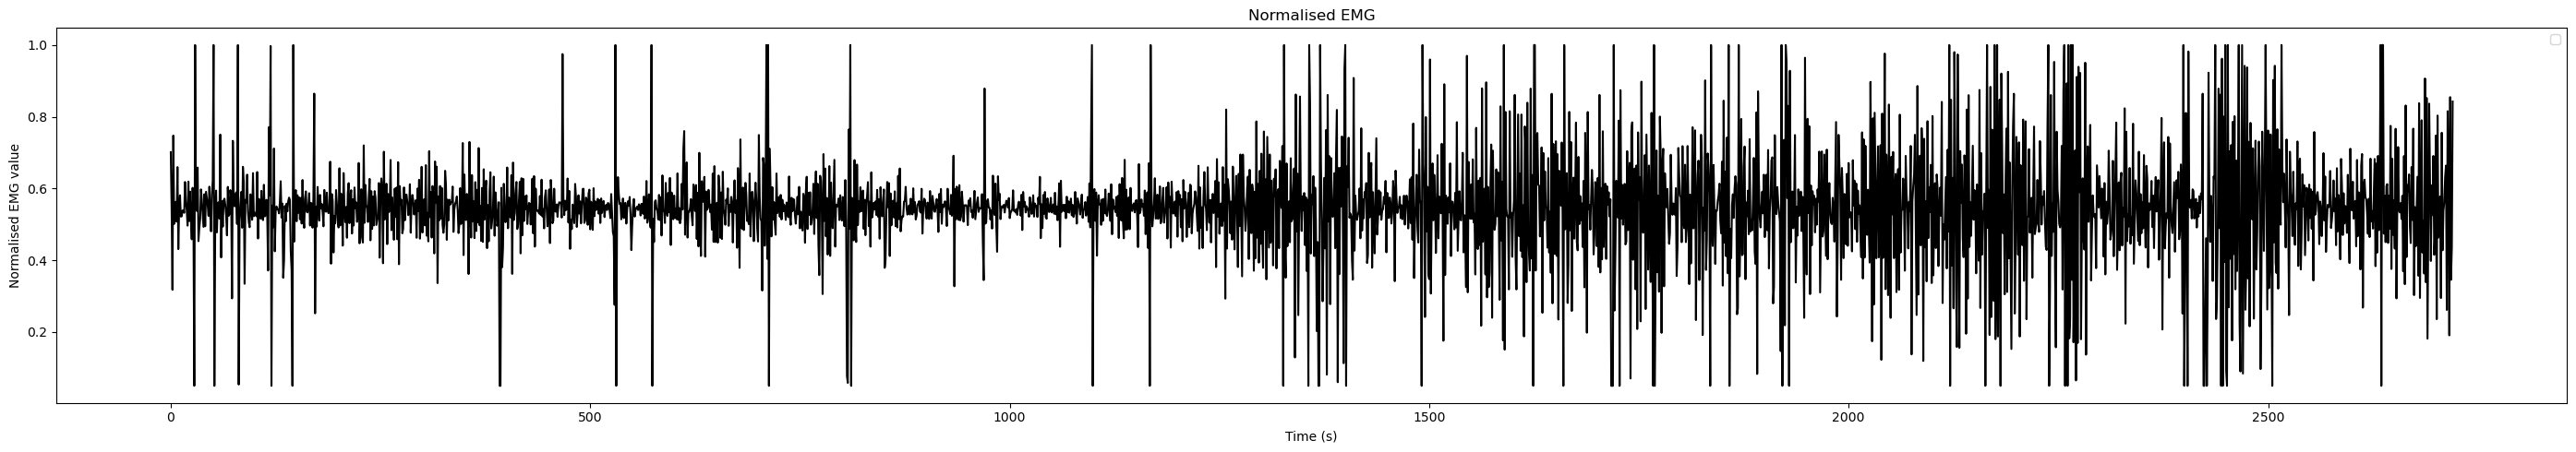

In [568]:
fig, (ax1) = plt.subplots(1, 1, sharex=True, figsize = (28, 5))
print(len(epochs))
print(len(EMG_norm))
x = len(EMG_norm) - len(epochs)
print(x)
n_x = len(epochs) - len(EMG_norm)
print(n_x)
# epochs = np.concatenate((epochs, np.zeros(n_x)), axis=0)
EMG_norm = np.concatenate((EMG_norm, np.zeros(n_x)), axis=0)
print(len(EMG_norm))

ax1.plot(epochs, EMG_norm, label='', color = 'black')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Normalised EMG value")

# Add legends
ax1.legend()
ax1.set_title('Normalised EMG')
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig(os.path.join(output_path, "normalized_emg.svg"), format="svg")

# Show the plots
plt.show()

In [569]:
# print(len(states))
# print(len(raw_delta)/fs)

6802579
6802579
0


C:\Users\andri\AppData\Local\Temp\ipykernel_14948\2124271400.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\andri\AppData\Local\Temp\ipykernel_14948\2124271400.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
C:\Users\andri\AppData\Local\Temp\ipykernel_14948\2124271400.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


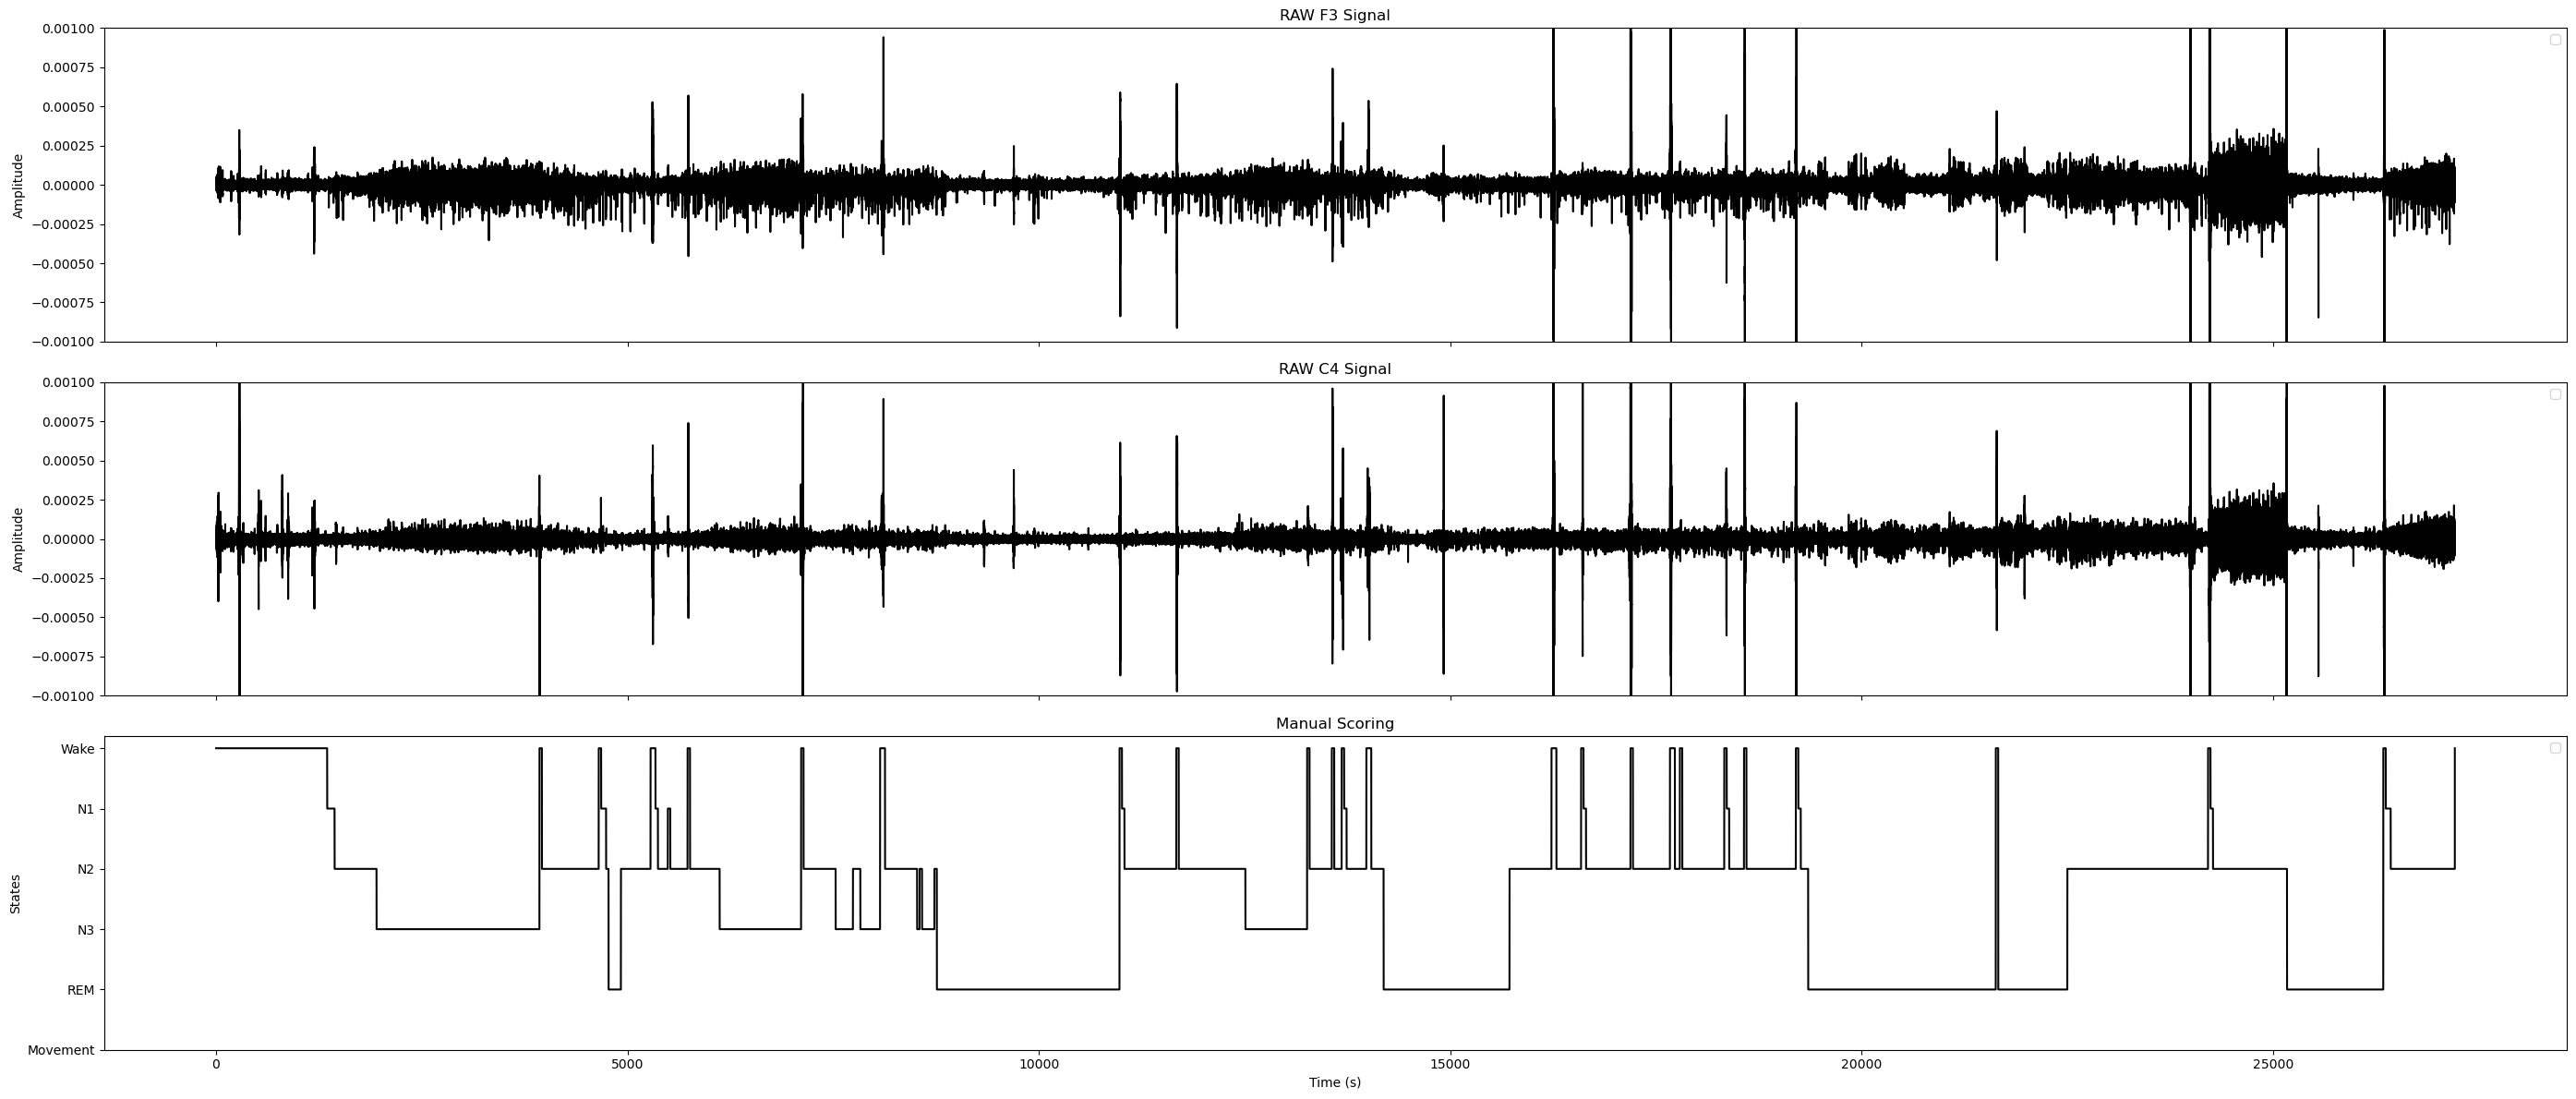

In [606]:
upsampled_states = states
x = (np.arange(len(raw_delta))/fs)
state_len = len(upsampled_states)
x_len = len(x)
print(state_len)
print(x_len)
dif = x_len - state_len
print(dif)


#upsampled_states = np.concatenate((upsampled_states, np.zeros(dif)), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(28, 12))

# Plot data on each subplot
ax1.plot(x, raw_sigma, label='', color='black')
ax2.plot(x, raw_theta, label='', color='black')
ax3.plot(x, upsampled_states, label='', color='black')

# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add axis titles
ax1.set_title('RAW F3 Signal')
ax2.set_title('RAW C4 Signal')
ax3.set_title('Manual Scoring')

ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Amplitude')
ax3.set_ylabel('States')
ax3.set_xlabel('Time (s)')

# Set y-axis limits (example values, adjust as needed)
ax1.set_ylim(-0.001, 0.001)  # Replace with appropriate limits for your data
ax2.set_ylim(-0.001, 0.001)  # Replace with appropriate limits for your data

# mask the y-axis values with actual sleep stages
ax3.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax3.invert_yaxis()

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "raw_signals.svg"), format = "svg")
# Show the plots
plt.show()

2721
2721
1


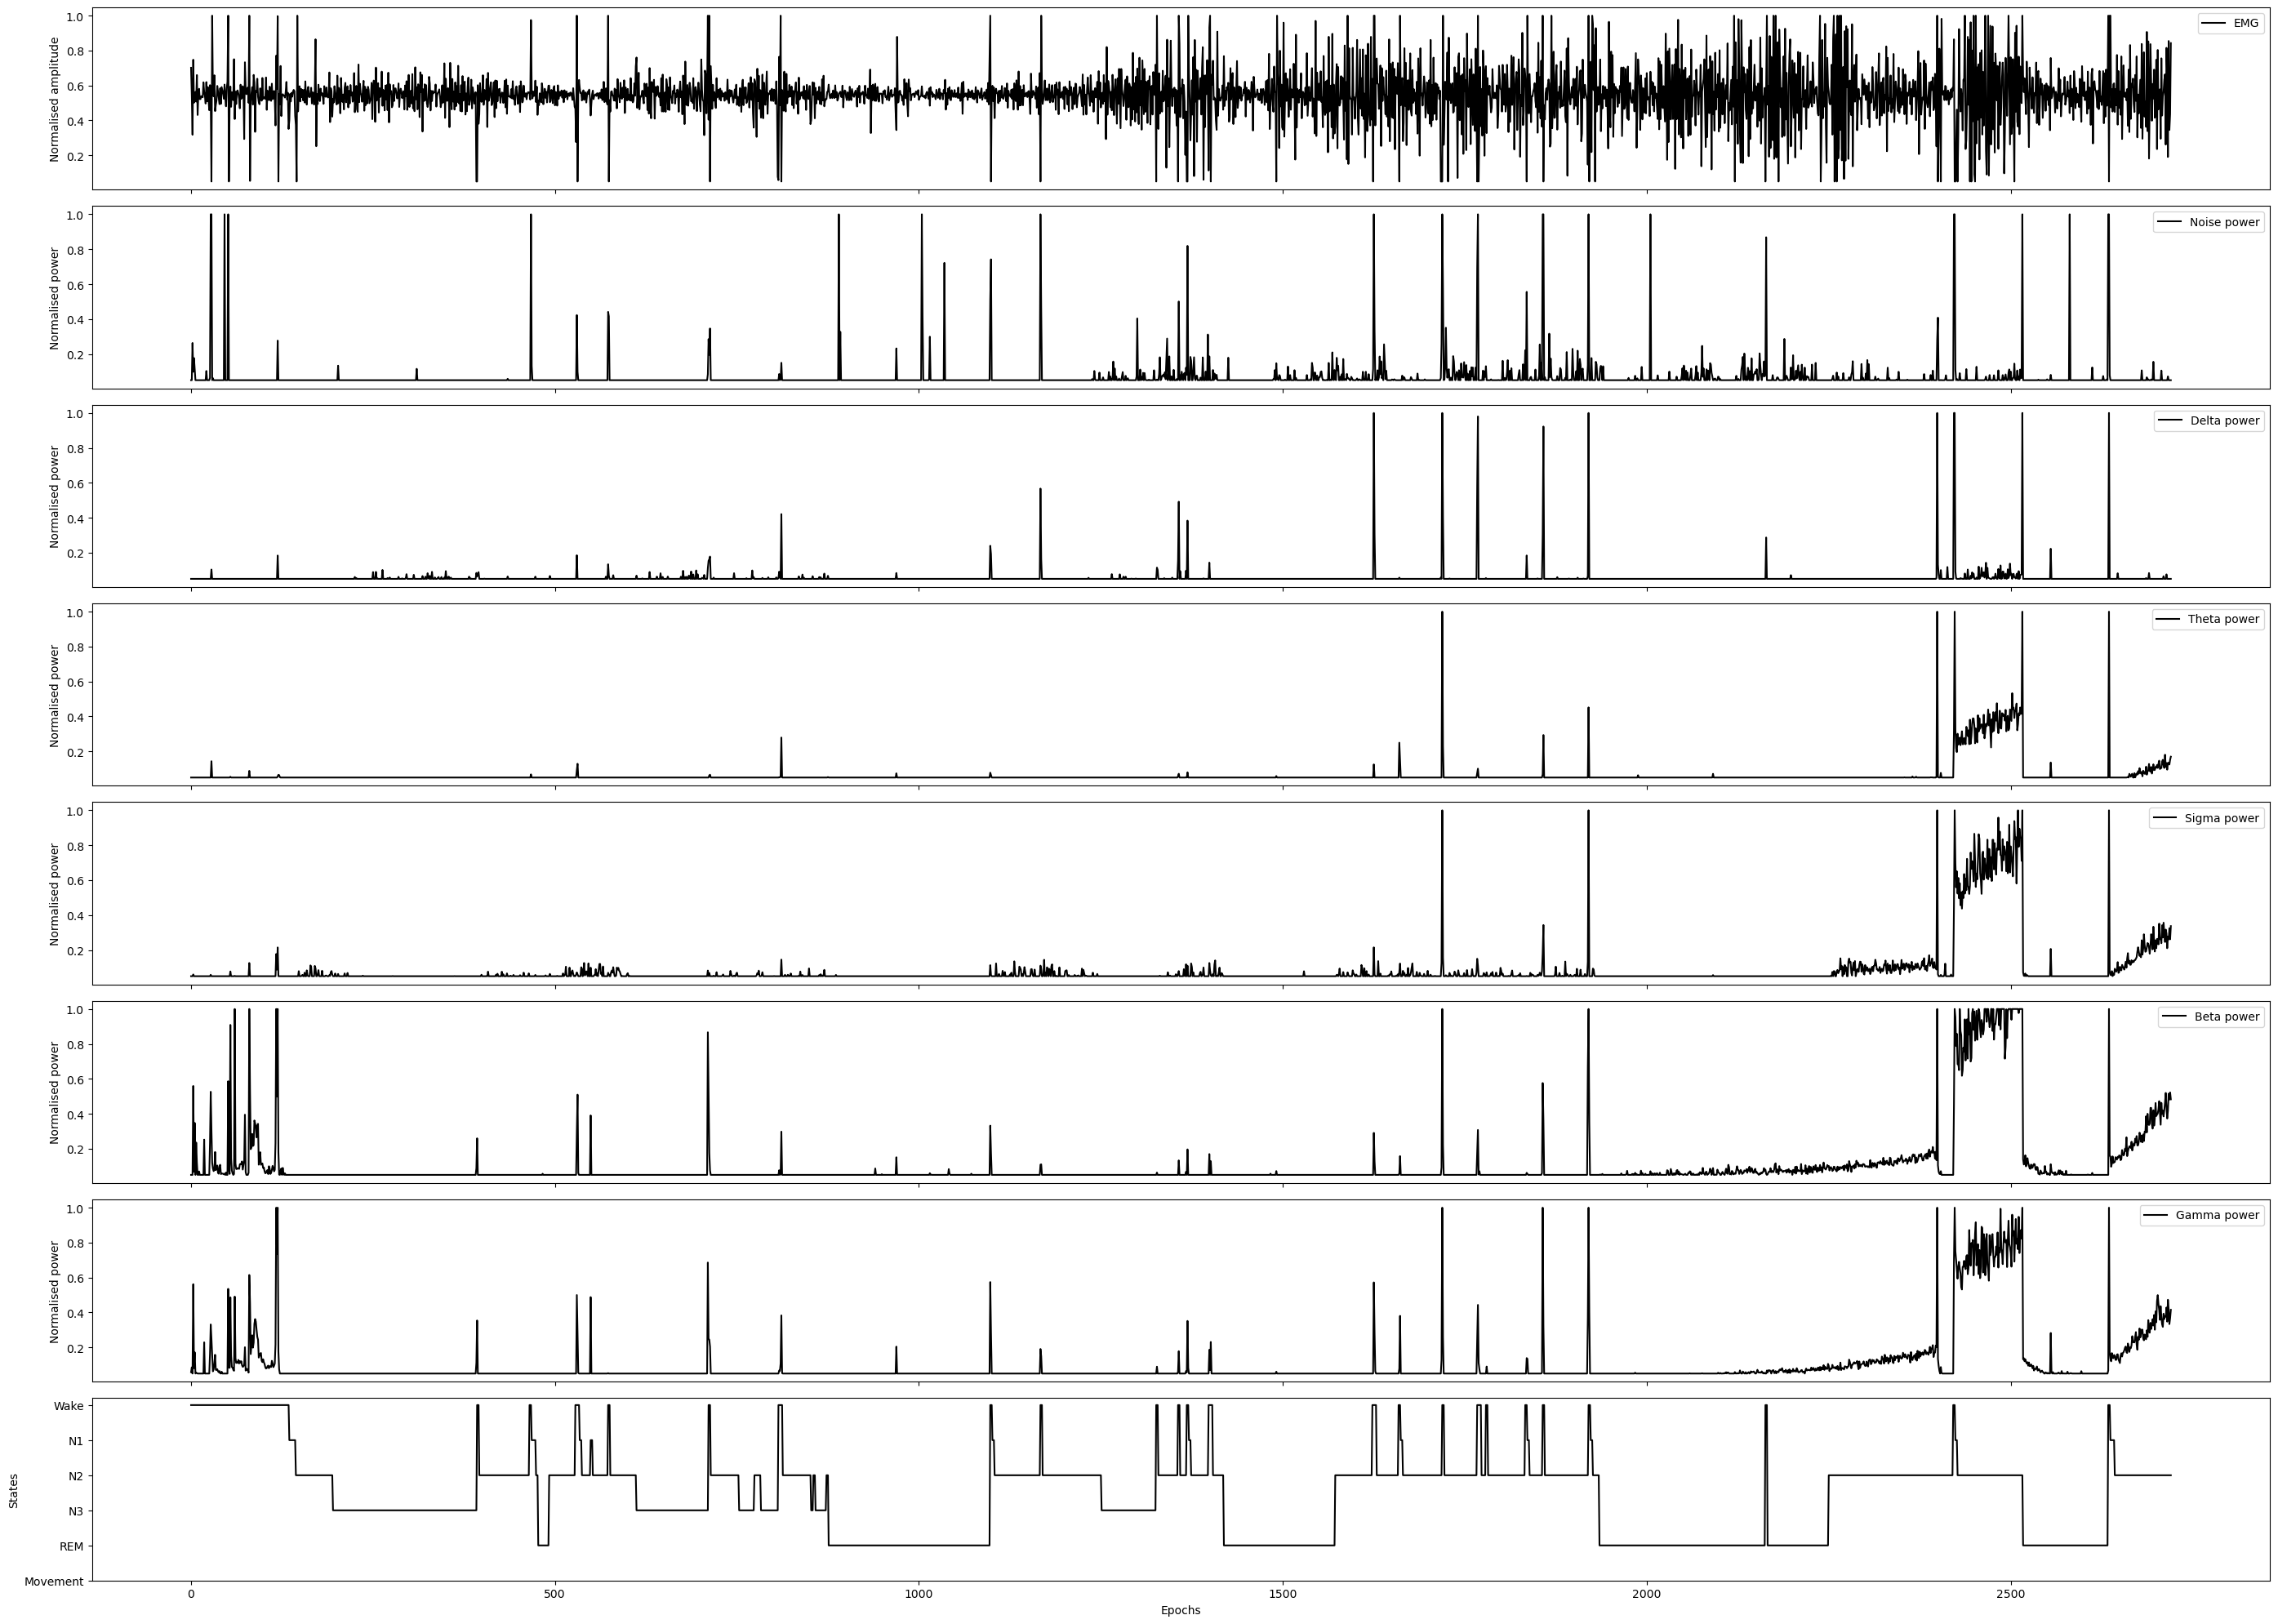

In [571]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, sharex=True, figsize = (28, 20))
# epochs = np.arange(len(EMG_norm))
print(len(EMG_norm))
print(len(noise_norm))
print(dif)

# Plot data on each subplot
ax1.plot(epochs, EMG_norm, label='EMG', color = 'black')
ax2.plot(epochs, noise_norm, label='Noise power', color = 'black')
ax3.plot(epochs, delta_norm, label='Delta power', color = 'black')
ax4.plot(epochs, theta_norm, label='Theta power', color = 'black')
ax5.plot(epochs, sigma_norm, label='Sigma power', color = 'black')
ax6.plot(epochs, beta_norm, label='Beta power', color = 'black')
ax7.plot(epochs, gamma_norm, label='Gamma power', color = 'black')
ax8.plot(epochs, majority_scores, label='Mapped scores', color = 'black')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
ax5.legend(loc='upper right')
ax6.legend(loc='upper right')
ax7.legend(loc='upper right')

ax1.set_ylabel('Normalised amplitude')
ax2.set_ylabel('Normalised power')
ax3.set_ylabel('Normalised power')
ax4.set_ylabel('Normalised power')
ax5.set_ylabel('Normalised power')
ax6.set_ylabel('Normalised power')
ax7.set_ylabel('Normalised power')
ax8.set_ylabel('States')

ax8.set_xlabel('Epochs')
ax8.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax8.invert_yaxis()
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig(os.path.join(output_path, "power_bands.svg"), format="svg")

# Show the plots
plt.show()

## Indices

### Wei indexes

#### Get indices

In [572]:
# Raw indices

index_w = index_W(delta_norm, gamma_norm, EMG_norm)
index_n = index_N(delta_norm, sigma_norm, gamma_norm)
index_r = index_R(delta_norm, theta_norm, sigma_norm, EMG_norm)
index_1 = Index_1(delta_norm, gamma_norm, EMG_norm)
index_2 = Index_2(delta_norm, theta_norm, sigma_norm)
index_3 = Index_3(delta_norm, theta_norm, gamma_norm)
index_4 = Index_4(delta_norm, theta_norm)

# Taking the log of the indices

index_w_log = np.log(index_w)
index_n_log = np.log(index_n)
index_r_log = np.log(index_r)
index_1_log = np.log(index_1)
index_2_log = np.log(index_2)
index_3_log = np.log(index_3)
index_4_log = np.log(index_4)

# Normalizing the indices

index_w_norm = wei_normalizing(index_w_log)
index_n_norm = wei_normalizing(index_n_log)
index_r_norm = wei_normalizing(index_r_log)
index_1_norm = wei_normalizing(index_1_log)
index_2_norm = wei_normalizing(index_2_log)
index_3_norm = wei_normalizing(index_3_log)
index_4_norm = wei_normalizing(index_4_log)

# Smoothing the indices

index_w_smoothed = np.convolve(np.convolve(np.convolve(index_w_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_n_smoothed = np.convolve(np.convolve(np.convolve(index_n_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_r_smoothed = np.convolve(np.convolve(np.convolve(index_r_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_1_smoothed = np.convolve(np.convolve(np.convolve(index_1_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_2_smoothed = np.convolve(np.convolve(np.convolve(index_2_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_3_smoothed = np.convolve(np.convolve(np.convolve(index_3_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_4_smoothed = np.convolve(np.convolve(np.convolve(index_4_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

#### Save wei features matrix

In [573]:
wei_features = np.column_stack((index_w_smoothed, index_n_smoothed, index_r_smoothed, index_1_smoothed, index_2_smoothed, index_3_smoothed, index_4_smoothed, noise_smoothed, theta_smoothed, delta_smoothed))
#np.save('Wei_features.npy', wei_features)

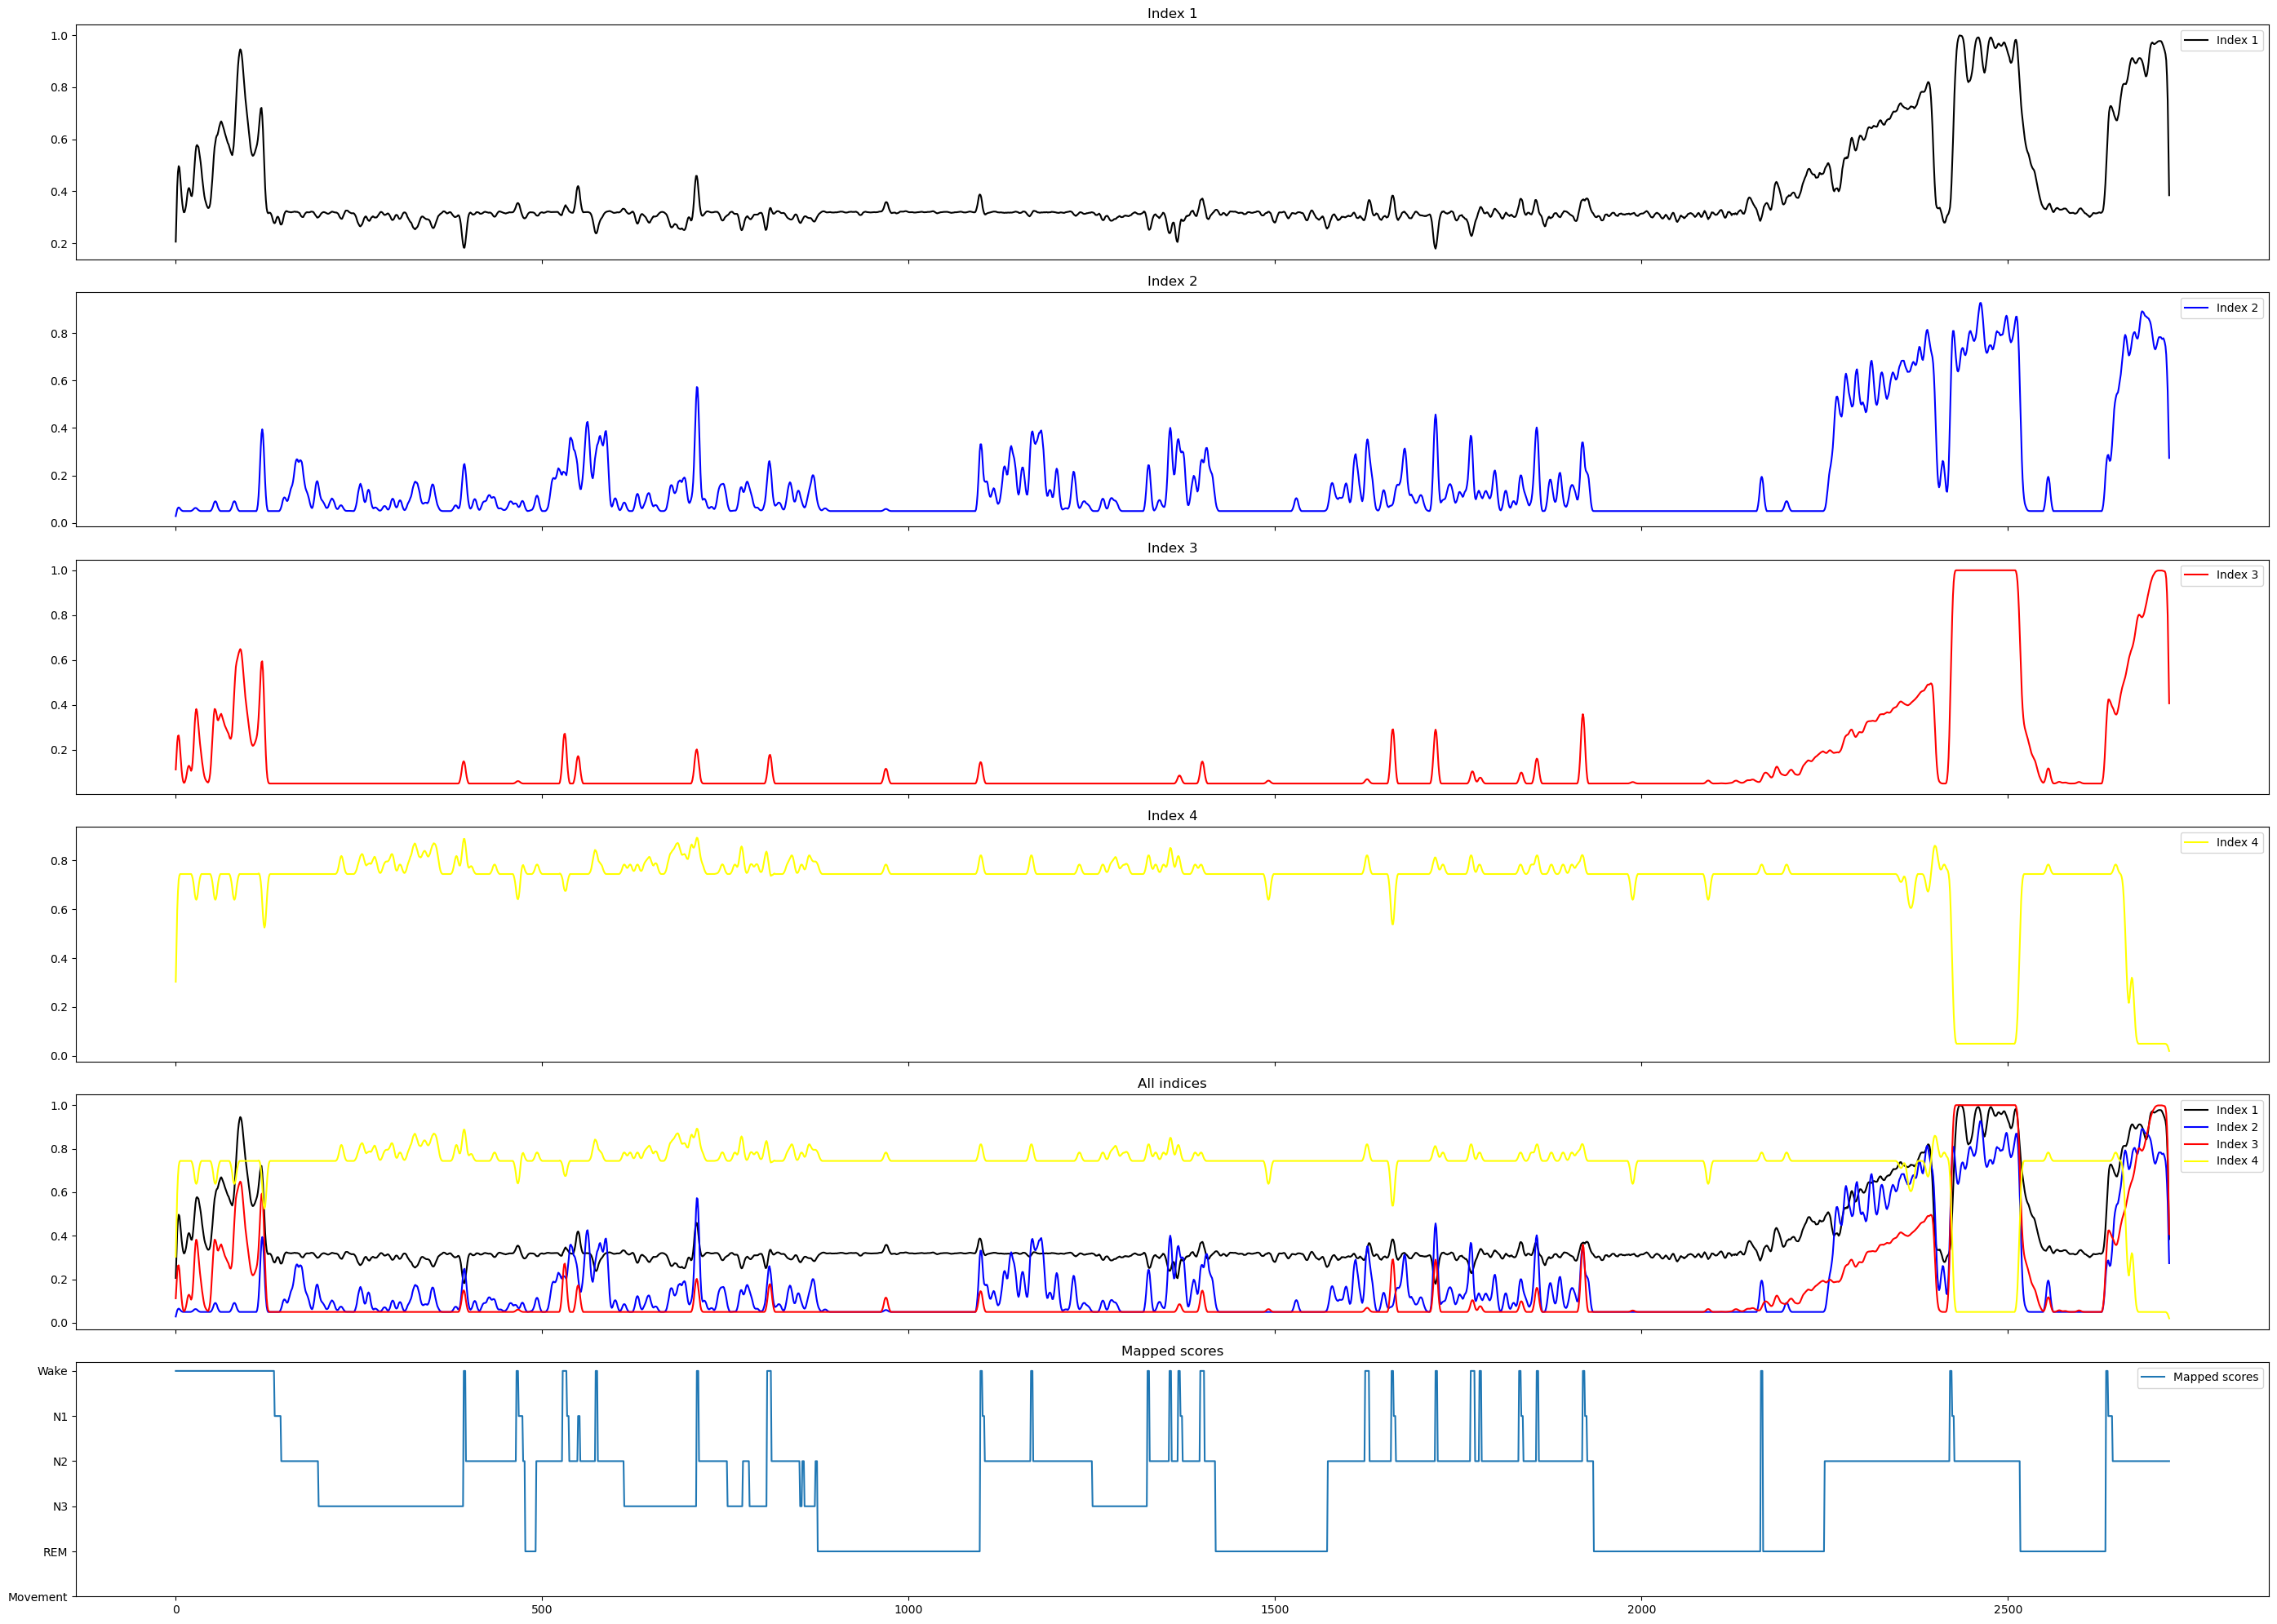

In [574]:
# All additional indices

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, figsize = (28, 20))

# Plot data on each subplot
ax1.plot(epochs, index_1_smoothed, label='Index 1', color='black')
ax2.plot(epochs, index_2_smoothed, label='Index 2', color='blue')
ax3.plot(epochs, index_3_smoothed, label='Index 3', color='red')
ax4.plot(epochs, index_4_smoothed, label='Index 4', color='Yellow')
ax5.plot(epochs, index_1_smoothed, label='Index 1', color='black')
ax5.plot(epochs, index_2_smoothed, label='Index 2', color='blue')
ax5.plot(epochs, index_3_smoothed, label='Index 3', color='red')
ax5.plot(epochs, index_4_smoothed, label='Index 4', color='Yellow')
ax6.plot(epochs, majority_scores, label='Mapped scores')


# Add legends
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()


# Add titles
ax1.set_title('Index 1')
ax2.set_title('Index 2')
ax3.set_title('Index 3')
ax4.set_title('Index 4')
ax5.set_title('All indices')
ax6.set_title('Mapped scores')

ax6.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax6.invert_yaxis()
# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "extra-indices.svg"), format="svg")
# Show the plots
plt.show()

In [575]:
# Wei
index_Wake = [[],[],[],[]]
index_N1 = [[],[],[],[]]
index_N2 = [[],[],[],[]]
index_N3 = [[],[],[],[]]
index_REM = [[],[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    index_Wake[0].append(index_1_smoothed[i])
    index_Wake[1].append(index_2_smoothed[i])
    index_Wake[2].append(index_3_smoothed[i])
    index_Wake[3].append(index_4_smoothed[i])

  elif el == 'N1':
    index_N1[0].append(index_1_smoothed[i])
    index_N1[1].append(index_2_smoothed[i])
    index_N1[2].append(index_3_smoothed[i])
    index_N1[3].append(index_4_smoothed[i])

  elif el == 'N2':
    index_N2[0].append(index_1_smoothed[i])
    index_N2[1].append(index_2_smoothed[i])
    index_N2[2].append(index_3_smoothed[i])
    index_N2[3].append(index_4_smoothed[i])

  elif el == 'N3':
    index_N3[0].append(index_1_smoothed[i])
    index_N3[1].append(index_2_smoothed[i])
    index_N3[2].append(index_3_smoothed[i])
    index_N3[3].append(index_4_smoothed[i])

  elif el == 'REM':
    index_REM[0].append(index_1_smoothed[i])
    index_REM[1].append(index_2_smoothed[i])
    index_REM[2].append(index_3_smoothed[i])
    index_REM[3].append(index_4_smoothed[i])

# Wei
wake_1 = np.average(index_Wake[0])
wake_2 = np.average(index_Wake[1])
wake_3 = np.average(index_Wake[2])
wake_4 = np.average(index_Wake[3])
N1_1 = np.average(index_N1[0])
N1_2 = np.average(index_N1[1])
N1_3 = np.average(index_N1[2])
N1_4 = np.average(index_N1[3])
N2_1 = np.average(index_N2[0])
N2_2 = np.average(index_N2[1])
N2_3 = np.average(index_N2[2])
N2_4 = np.average(index_N2[3])
N3_1 = np.average(index_N3[0])
N3_2 = np.average(index_N3[1])
N3_3 = np.average(index_N3[2])
N3_4 = np.average(index_N3[3])
REM_1 = np.average(index_REM[0])
REM_2 = np.average(index_REM[1])
REM_3 = np.average(index_REM[2])
REM_4 = np.average(index_REM[3])

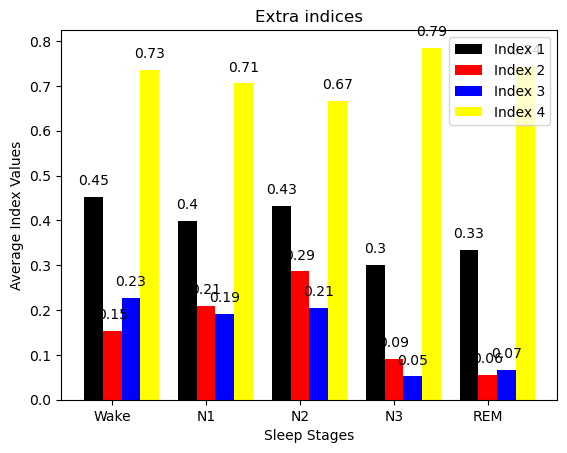

In [576]:
plt.subplot(1, 1, 1)
categories = ['Wake', 'N1', "N2", "N3", 'REM']
index_types = ['Index_1', 'Index_2', 'Index_3', 'Index_4']
values_1 = [wake_1, N1_1, N2_1, N3_1, REM_1]
values_2 = [wake_2, N1_2, N2_2, N3_2, REM_2]
values_3 = [wake_3, N1_3, N2_3, N3_3, REM_3]
values_4 = [wake_4, N1_4, N2_4, N3_4, REM_4]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_1, width=bar_width, label='Index 1', color = 'black')
plt.bar(x, values_2, width=bar_width, label='Index 2', color = 'red',)
plt.bar(x + bar_width, values_3, width=bar_width, label='Index 3', color = 'blue')
plt.bar(x +  (2 * bar_width), values_4, width=bar_width, label='Index 4', color = 'yellow')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Extra indices')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_1[i] + 0.02, str(round(values_1[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_2[i] + 0.02, str(round(values_2[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_3[i] + 0.02, str(round(values_3[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + (2 * bar_width), values_4[i] + 0.02, str(round(values_4[i], 2)), ha='center', va='bottom')

plt.savefig(os.path.join(output_path, "extra_indices_barplot.svg"), format="svg")

#### Main indices plots

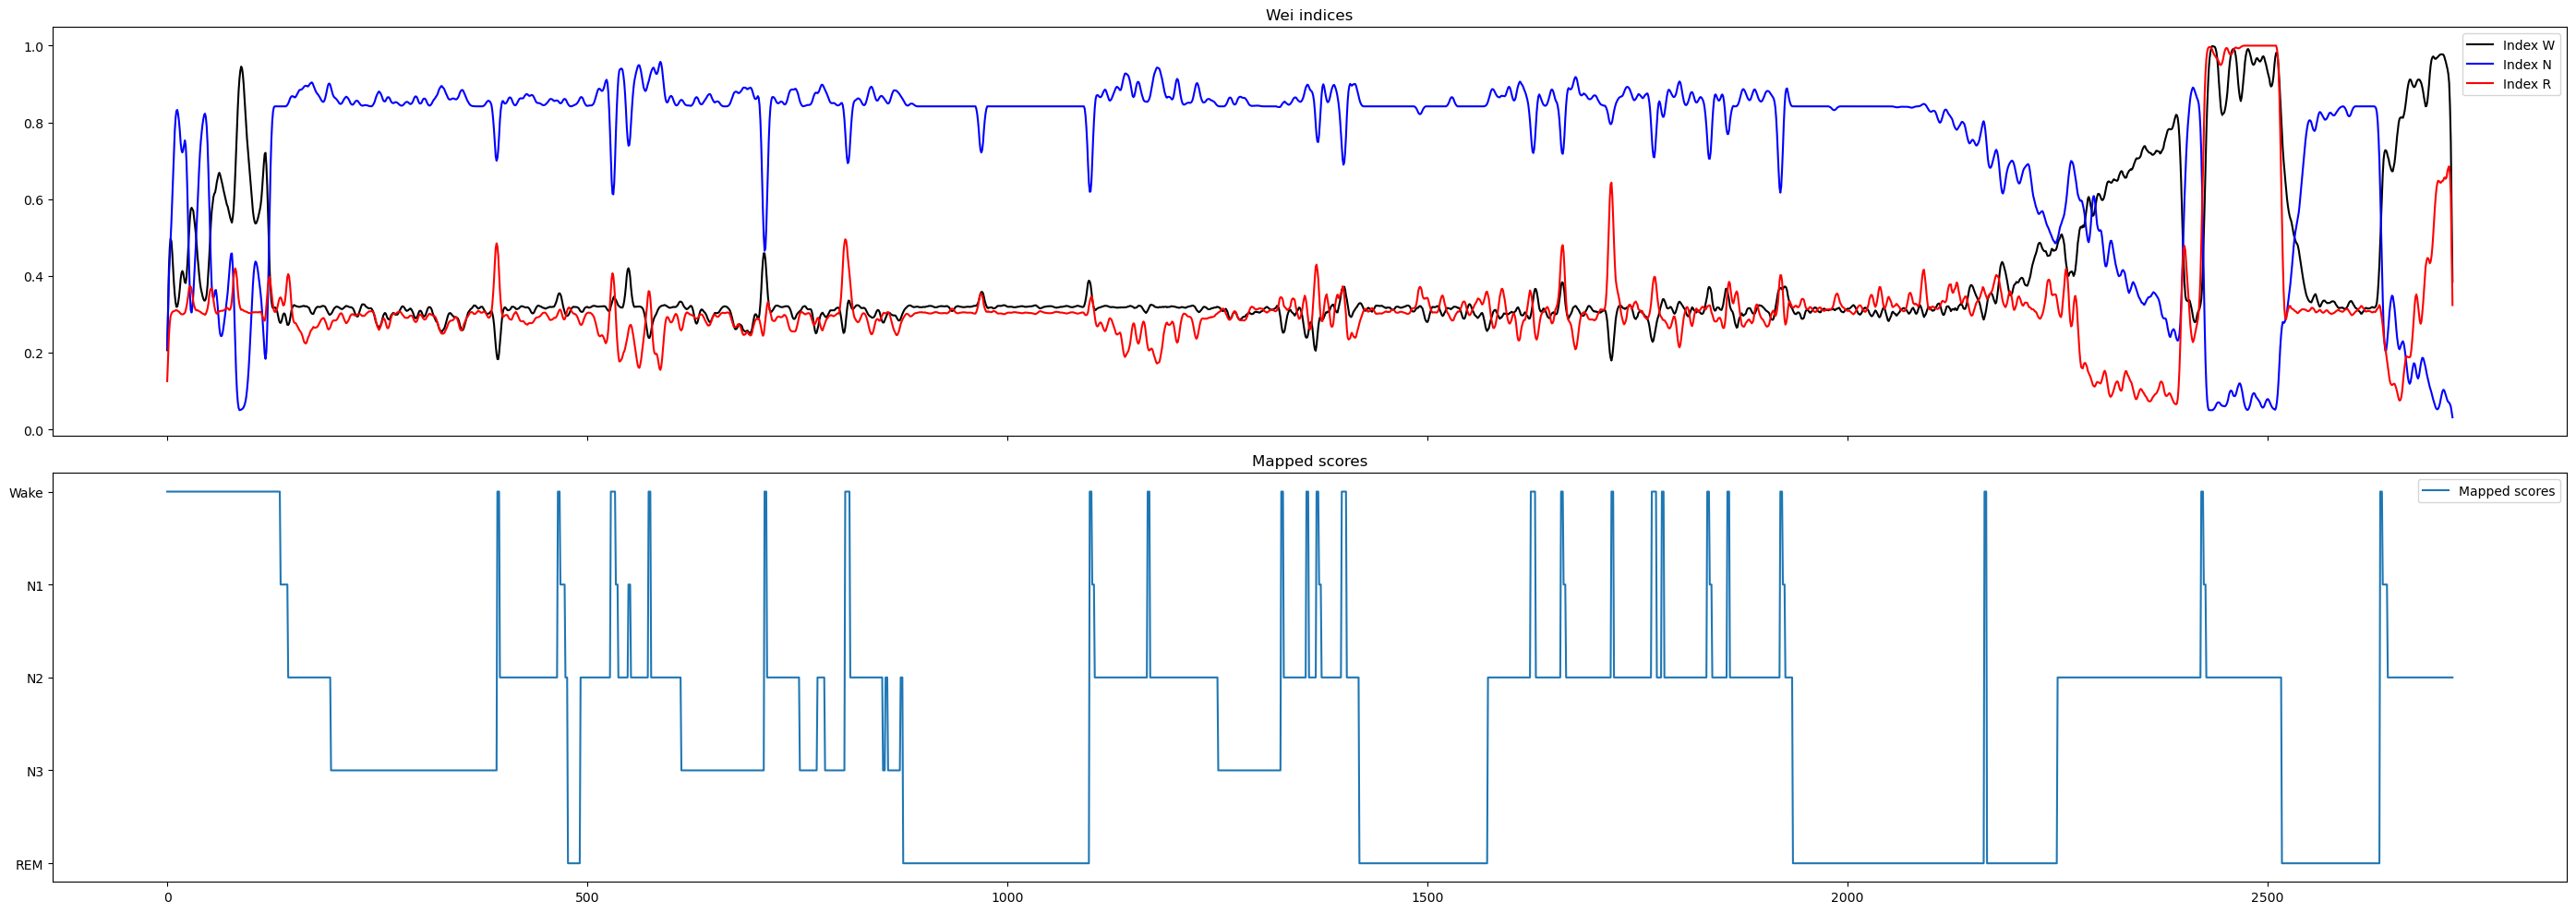

In [577]:
# All main indices

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (28, 10))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Index W', color='black')
ax1.plot(epochs, index_n_smoothed, label='Index N', color='blue')
ax1.plot(epochs, index_r_smoothed, label='Index R', color='red')

ax2.plot(epochs, majority_scores, label='Mapped scores')


# Add legends
ax1.legend()
ax2.legend()


# Add titles
ax1.set_title('Wei indices')
ax2.set_title('Mapped scores')

ax2.set_yticks(ticks=[0, 1, 2, 3, 4], labels=["Wake", "N1", "N2", "N3", "REM"])
ax2.invert_yaxis()
# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "wei_all-indices.svg"), format="svg")
# Show the plots
plt.show()

### New indexes

#### New WAKE (define and get index)

##### Compute new index + function

In [578]:
nindex_w = nindex_W(theta_norm, gamma_norm, EMG_norm)
nindex_w_log = np.log(nindex_w)
nindex_w_norm = wei_normalizing(nindex_w_log)
nindex_w_smoothed = np.convolve(np.convolve(np.convolve(nindex_w_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

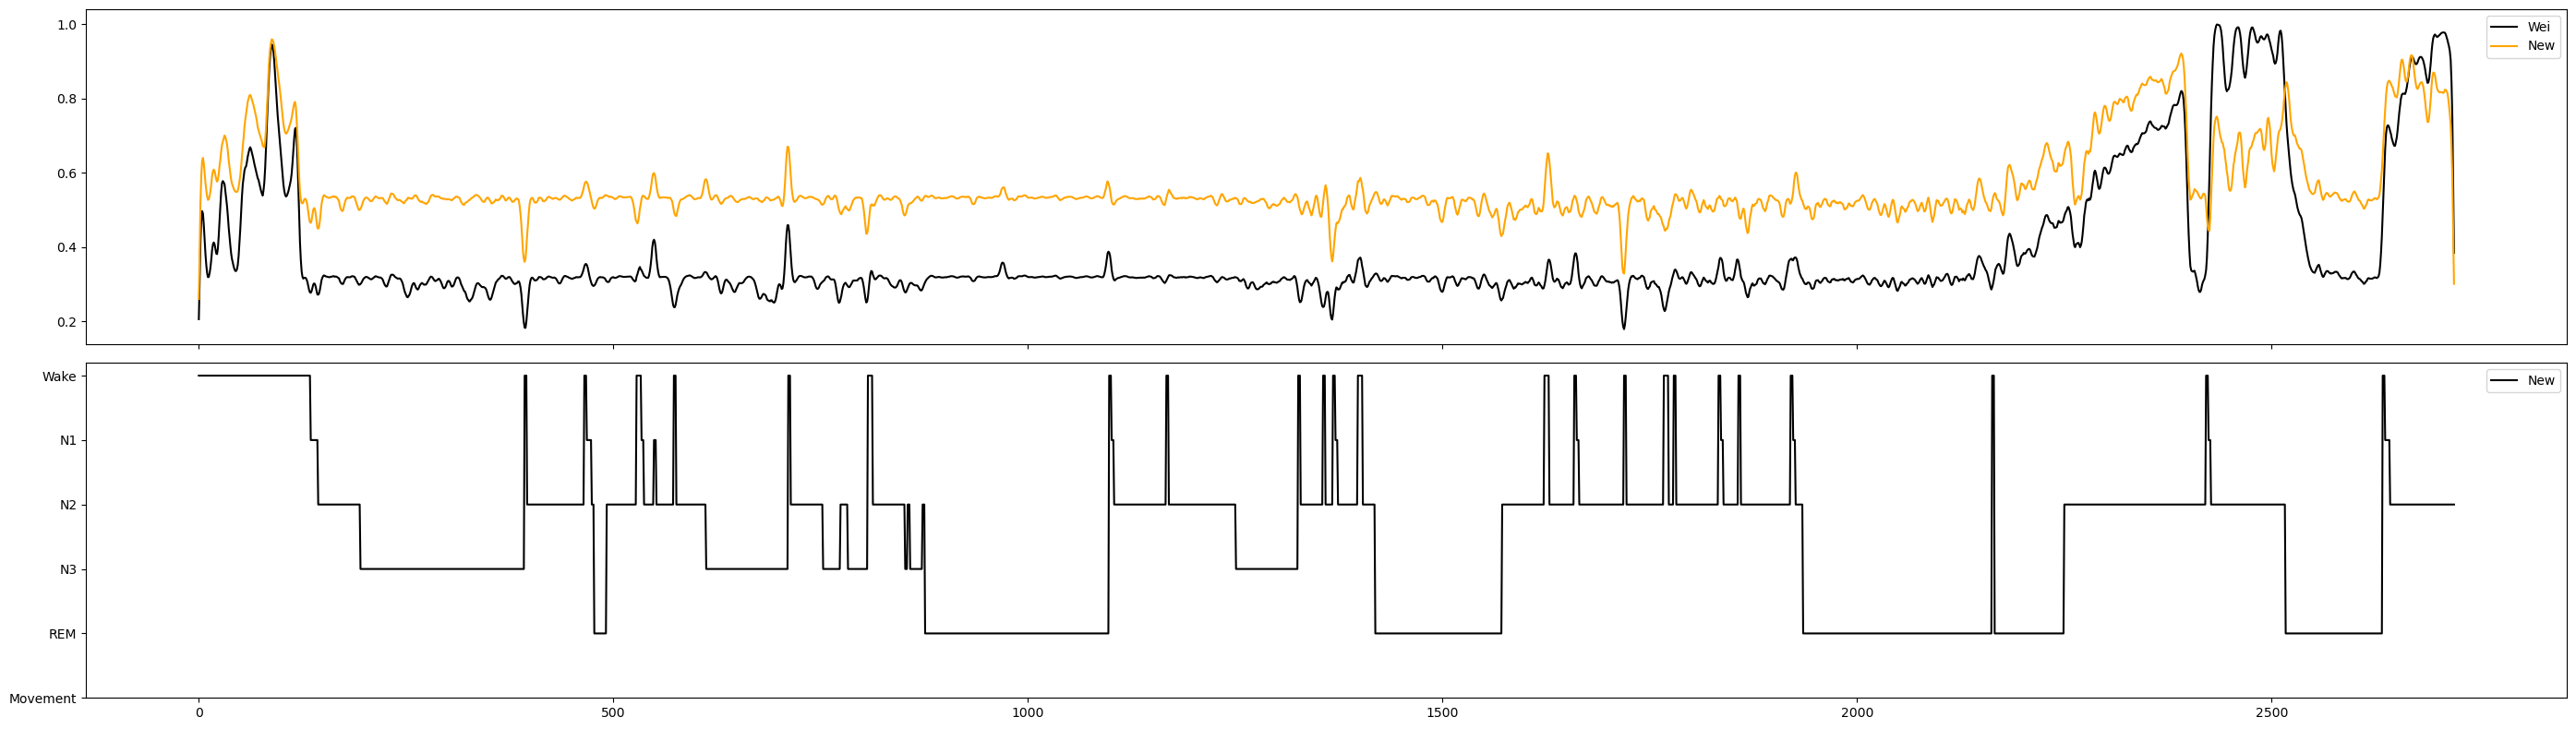

In [579]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (28, 8))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Wei', color = 'black')
ax1.plot(epochs, nindex_w_smoothed, label='New', color = 'orange')
ax2.plot(epochs, majority_scores, label='New', color = 'black')

# Add legends
ax1.legend()
ax2.legend()

ax2.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax2.invert_yaxis()

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "index-w_wei-vs-new.svg"), format="svg")
# Show the plots
plt.show()

##### All indices plot

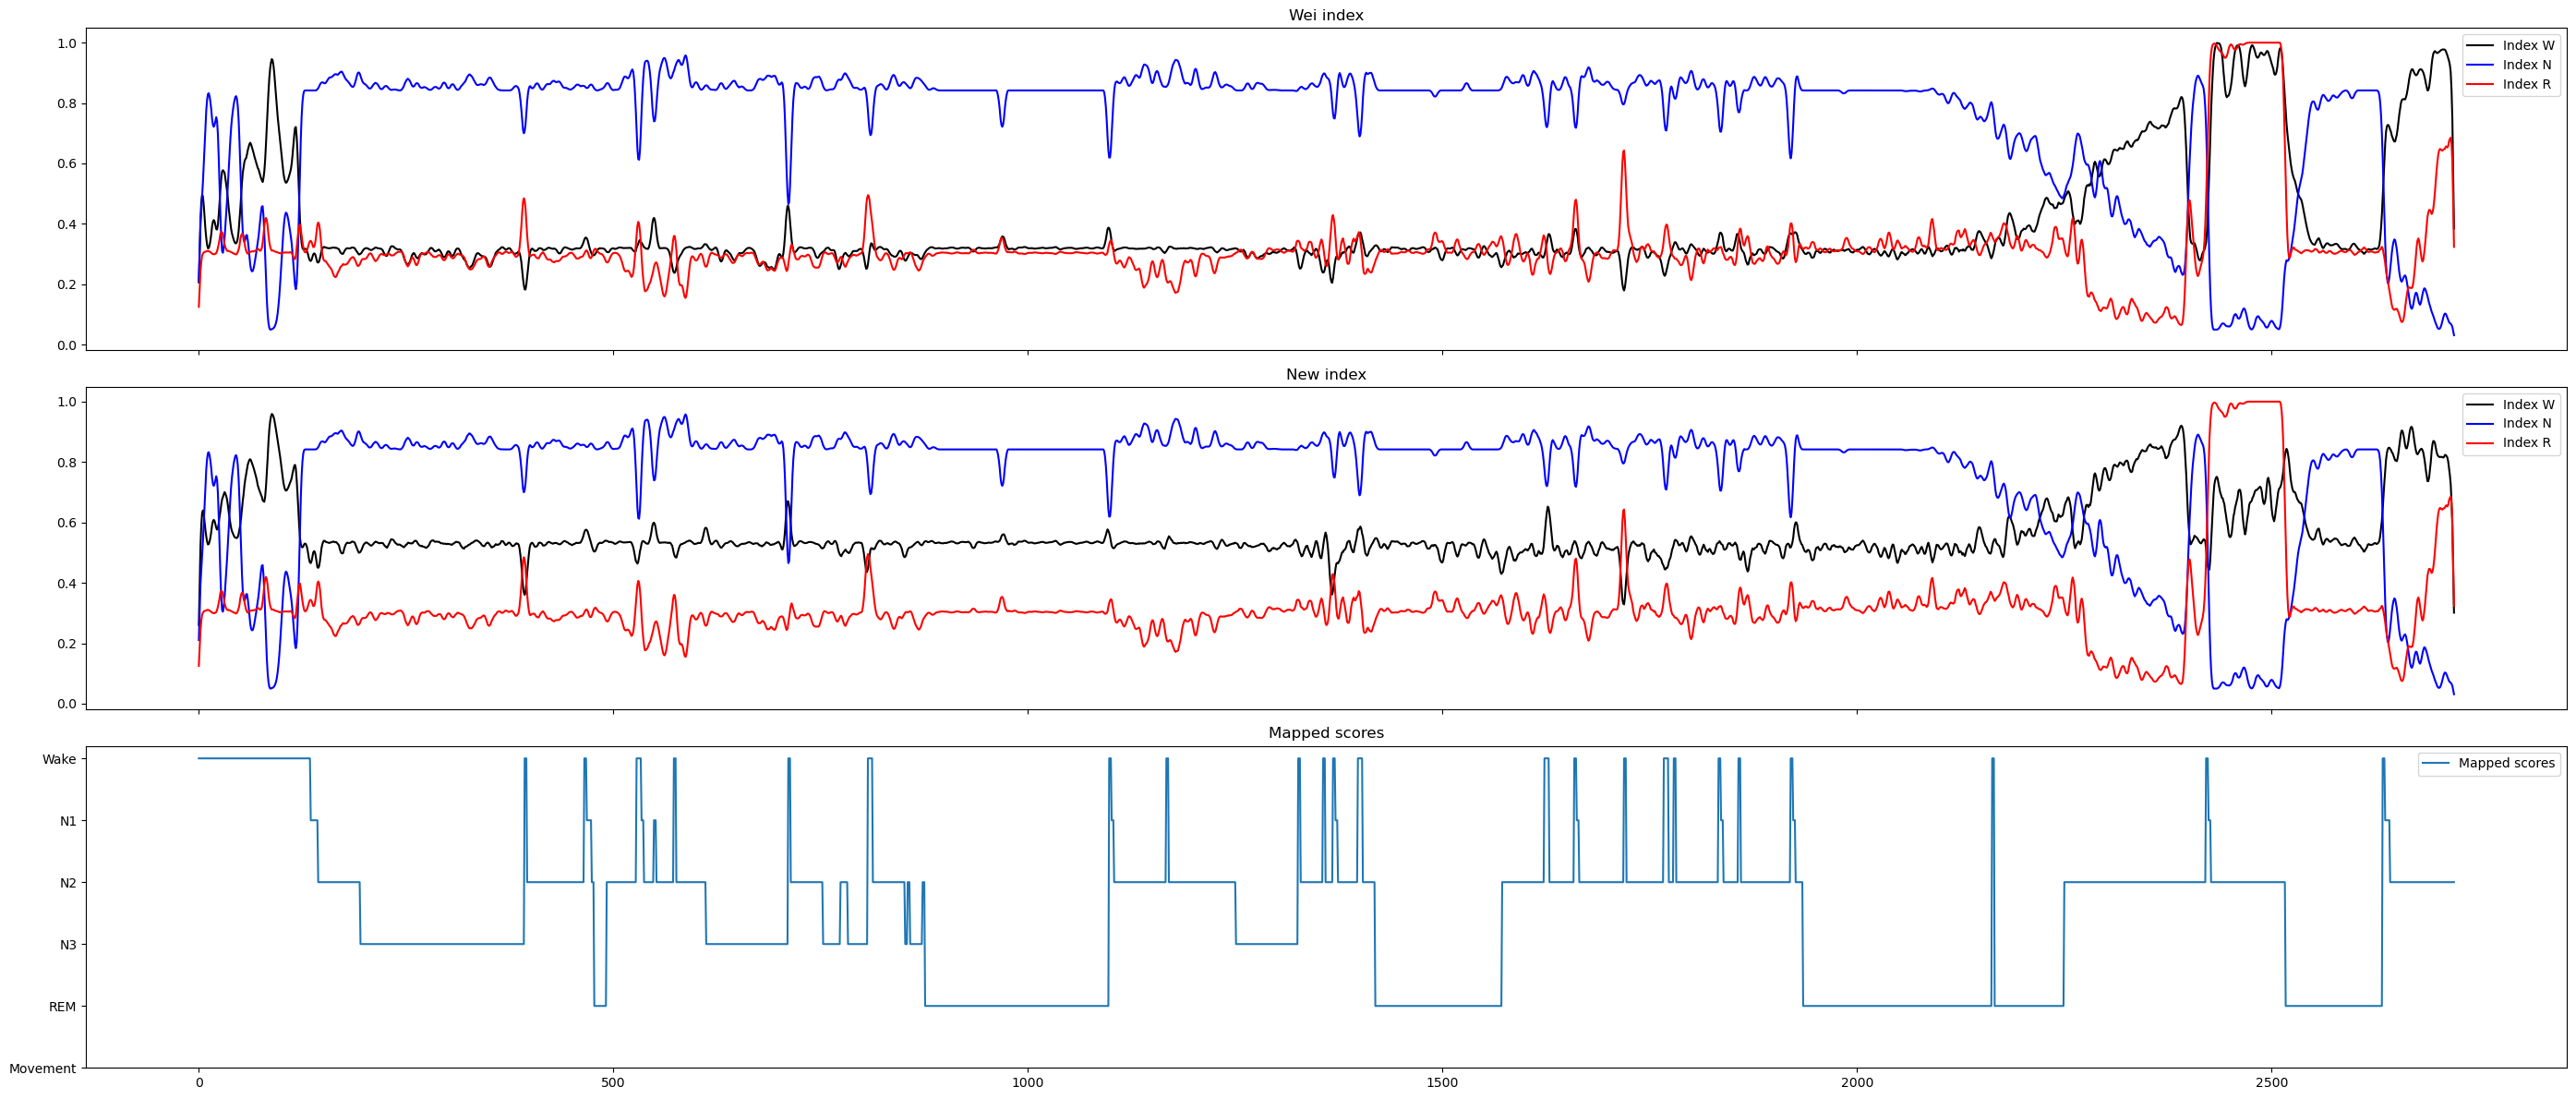

In [580]:
# All indices smoothed for better visualisation

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 12))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax1.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax1.plot(epochs, index_r_smoothed, label='Index R', color ='red')

ax2.plot(epochs, nindex_w_smoothed, label='Index W', color ='black')
ax2.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax2.plot(epochs, index_r_smoothed, label='Index R', color ='red')


ax3.plot(epochs, majority_scores, label='Mapped scores')

# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei index')
ax2.set_title('New index')
ax3.set_title('Mapped scores')

ax3.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax3.invert_yaxis()

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "index-w_wei-vs-new_all-indices.svg"), format="svg")

# Show the plots
plt.show()

##### Barplots

###### Prerequisites

In [581]:
# Wei
index_Wake = [[],[],[]]
index_N1 = [[],[],[]]
index_N2 = [[],[],[]]
index_N3 = [[],[],[]]
index_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    index_Wake[0].append(index_w_smoothed[i])
    index_Wake[1].append(index_r_smoothed[i])
    index_Wake[2].append(index_n_smoothed[i])

  elif el == 'N1':
    index_N1[0].append(index_w_smoothed[i])
    index_N1[1].append(index_r_smoothed[i])
    index_N1[2].append(index_n_smoothed[i])

  elif el == 'N2':
    index_N2[0].append(index_w_smoothed[i])
    index_N2[1].append(index_r_smoothed[i])
    index_N2[2].append(index_n_smoothed[i])

  elif el == 'N3':
    index_N3[0].append(index_w_smoothed[i])
    index_N3[1].append(index_r_smoothed[i])
    index_N3[2].append(index_n_smoothed[i])

  elif el == 'REM':
    index_REM[0].append(index_w_smoothed[i])
    index_REM[1].append(index_r_smoothed[i])
    index_REM[2].append(index_n_smoothed[i])

# New
nindex_Wake = [[],[],[]]
nindex_N1 = [[],[],[]]
nindex_N2 = [[],[],[]]
nindex_N3 = [[],[],[]]
nindex_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    nindex_Wake[0].append(nindex_w_smoothed[i])
    nindex_Wake[1].append(index_r_smoothed[i])
    nindex_Wake[2].append(index_n_smoothed[i])

  elif el == 'N1':
    nindex_N1[0].append(nindex_w_smoothed[i])
    nindex_N1[1].append(index_r_smoothed[i])
    nindex_N1[2].append(index_n_smoothed[i])

  elif el == 'N2':
    nindex_N2[0].append(nindex_w_smoothed[i])
    nindex_N2[1].append(index_r_smoothed[i])
    nindex_N2[2].append(index_n_smoothed[i])

  elif el == 'N3':
    nindex_N3[0].append(nindex_w_smoothed[i])
    nindex_N3[1].append(index_r_smoothed[i])
    nindex_N3[2].append(index_n_smoothed[i])

  elif el == 'REM':
    nindex_REM[0].append(nindex_w_smoothed[i])
    nindex_REM[1].append(index_r_smoothed[i])
    nindex_REM[2].append(index_n_smoothed[i])

In [582]:
# Wei
wake_w = np.average(index_Wake[0])
wake_r = np.average(index_Wake[1])
wake_n = np.average(index_Wake[2])
N1_w = np.average(index_N1[0])
N1_r = np.average(index_N1[1])
N1_n = np.average(index_N1[2])
N2_w = np.average(index_N2[0])
N2_r = np.average(index_N2[1])
N2_n = np.average(index_N2[2])
N3_w = np.average(index_N3[0])
N3_r = np.average(index_N3[1])
N3_n = np.average(index_N3[2])
REM_w = np.average(index_REM[0])
REM_r = np.average(index_REM[1])
REM_n = np.average(index_REM[2])

# New
nwake_w = np.average(nindex_Wake[0])
nwake_r = np.average(nindex_Wake[1])
nwake_n = np.average(nindex_Wake[2])
nN1_w = np.average(nindex_N1[0])
nN1_r = np.average(nindex_N1[1])
nN1_n = np.average(nindex_N1[2])
nN2_w = np.average(nindex_N2[0])
nN2_r = np.average(nindex_N2[1])
nN2_n = np.average(nindex_N2[2])
nN3_w = np.average(nindex_N3[0])
nN3_r = np.average(nindex_N3[1])
nN3_n = np.average(nindex_N3[2])
nREM_w = np.average(nindex_REM[0])
nREM_r = np.average(nindex_REM[1])
nREM_n = np.average(nindex_REM[2])

###### Barplots

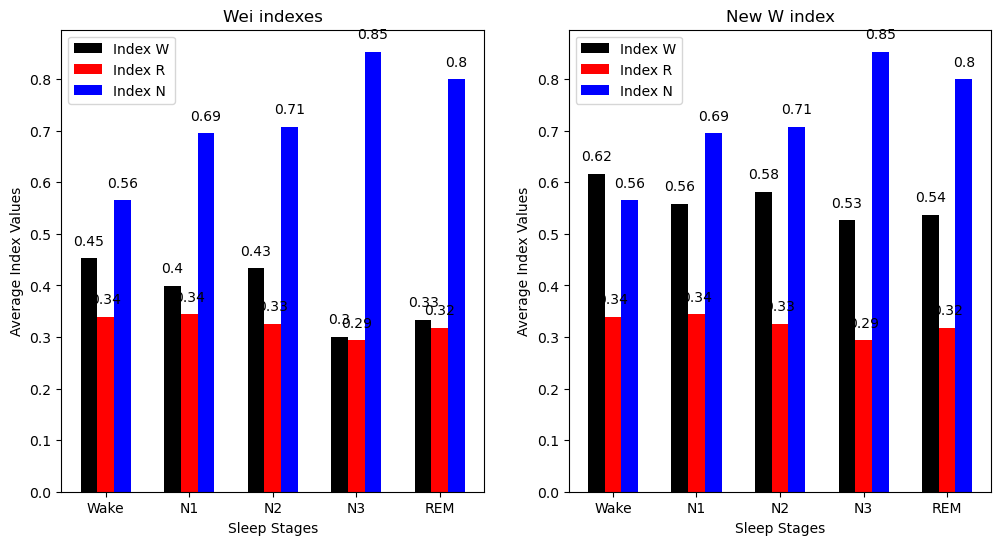

In [583]:
plt.figure(figsize=(12, 6))

# Wei indexes
plt.subplot(1, 2, 1)
categories = ['Wake', 'N1', 'N2', 'N3', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, N1_w, N2_w, N3_w, REM_w]
values_REM = [wake_r, N1_r, N2_r, N3_r, REM_r]
values_NREM = [wake_n, N1_n, N2_n, N3_n,REM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Wei indexes')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')




# New W index
plt.subplot(1, 2, 2)
categories = ['Wake', 'N1', "N2", "N3", 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [nwake_w, nN1_w, nN2_w, nN3_w, nREM_w]
values_REM = [nwake_r, nN1_r, nN2_r, nN3_r, nREM_r]
values_NREM = [nwake_n, nN1_n, nN2_n, nN3_n, nREM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('New W index')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')

plt.savefig(os.path.join(output_path, "index-w_wei-vs-new_all-indices_barplot.svg"), format="svg")

#### New REM (define and get index)

##### Compute new index + function

In [584]:
nindex_r = nindex_R(delta_norm, theta_norm, sigma_norm, EMG_norm, gamma_norm)
nindex_r_log = np.log(nindex_r)
nindex_r_norm = wei_normalizing(nindex_r_log)
nindex_r_smoothed = np.convolve(np.convolve(np.convolve(nindex_r_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

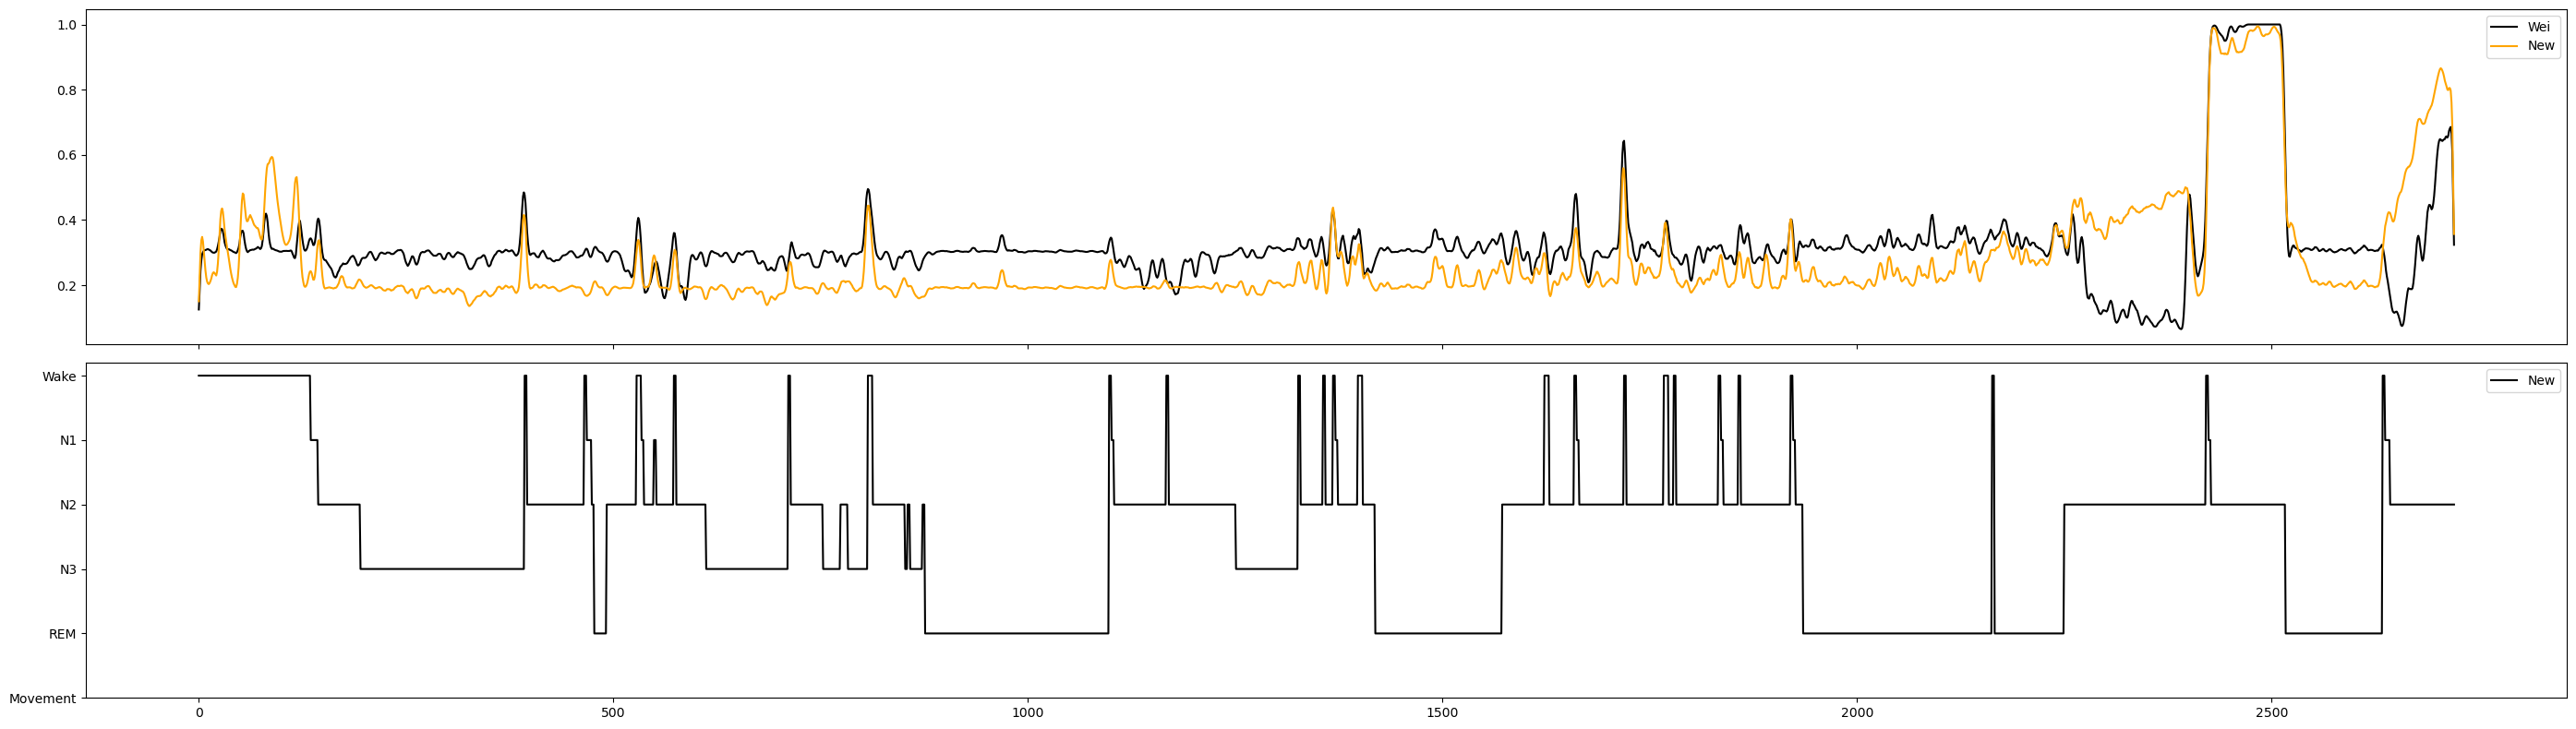

In [585]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (28, 8))

# Plot data on each subplot
ax1.plot(epochs, index_r_smoothed, label='Wei', color = 'black')
ax1.plot(epochs, nindex_r_smoothed, label='New', color = 'orange')
ax2.plot(epochs, majority_scores, label='New', color = 'black')

# Add legends
ax1.legend()
ax2.legend()
ax2.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax2.invert_yaxis()

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "index-r_wei-vs-new.svg"), format="svg")
# Show the plots
plt.show()

##### All indices plot

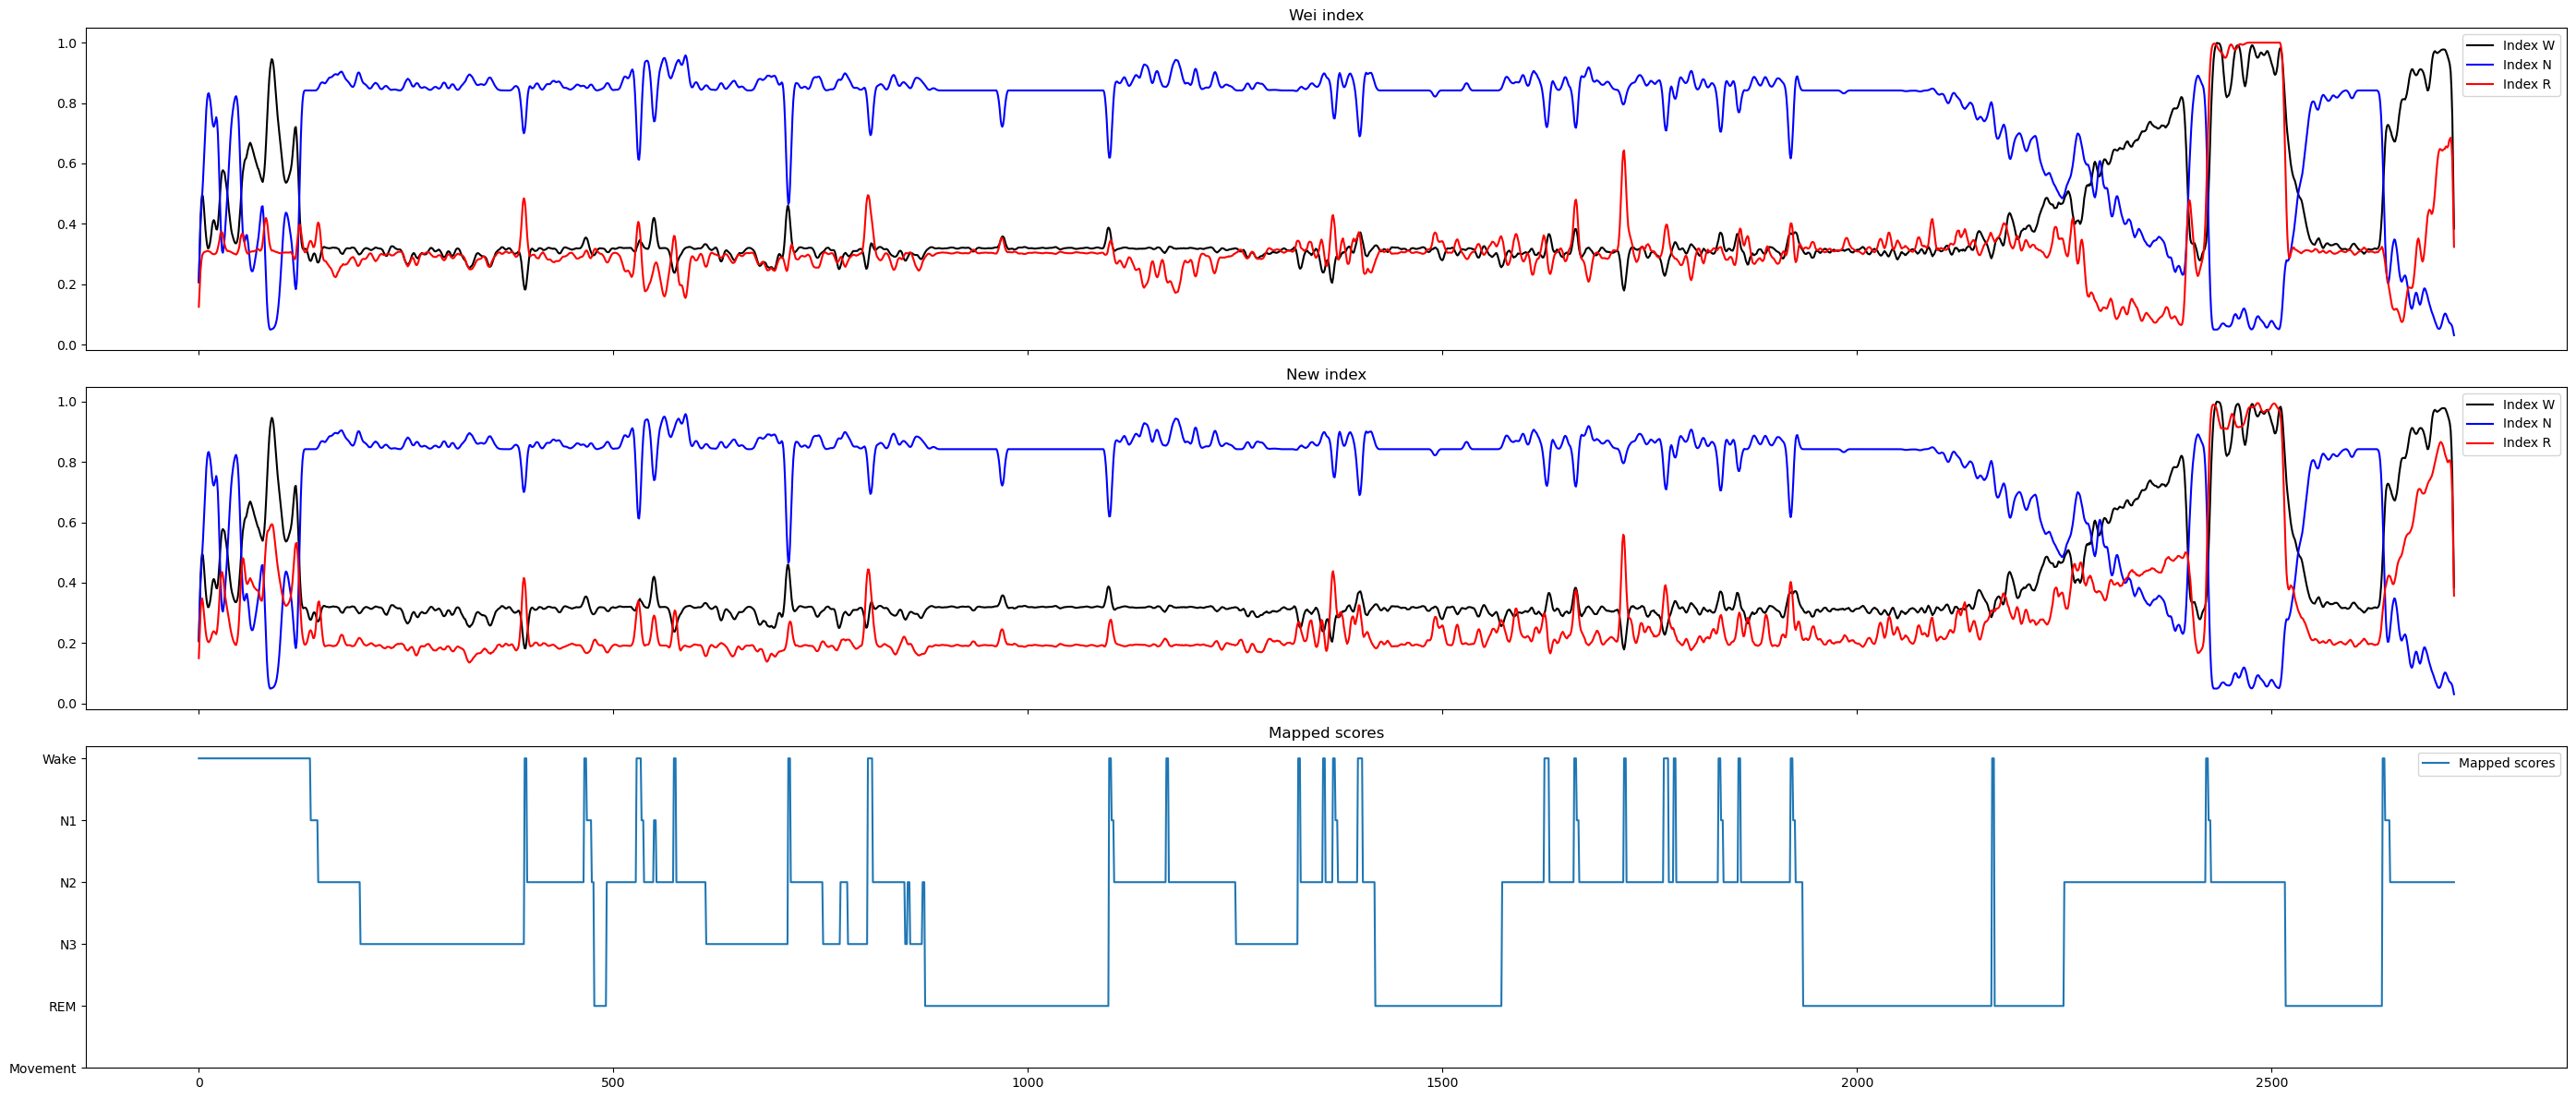

In [586]:
# All indices smoothed for better visualisation

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 12))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax1.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax1.plot(epochs, index_r_smoothed, label='Index R', color ='red')

ax2.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax2.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax2.plot(epochs, nindex_r_smoothed, label='Index R', color ='red')


ax3.plot(epochs, majority_scores, label='Mapped scores')

# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei index')
ax2.set_title('New index')
ax3.set_title('Mapped scores')
ax3.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax3.invert_yaxis()

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "index-r_wei-vs-new_all-indices.svg"), format="svg")

# Show the plots
plt.show()

##### Barplots

###### Prerequisites

In [587]:
# New
nindex_Wake = [[],[],[]]
nindex_N1 = [[],[],[]]
nindex_N2 = [[],[],[]]
nindex_N3 = [[],[],[]]
nindex_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    nindex_Wake[0].append(index_w_smoothed[i])
    nindex_Wake[1].append(nindex_r_smoothed[i])
    nindex_Wake[2].append(index_n_smoothed[i])

  elif el == 'N1':
    nindex_N1[0].append(index_w_smoothed[i])
    nindex_N1[1].append(nindex_r_smoothed[i])
    nindex_N1[2].append(index_n_smoothed[i])

  elif el == 'N2':
    nindex_N2[0].append(index_w_smoothed[i])
    nindex_N2[1].append(nindex_r_smoothed[i])
    nindex_N2[2].append(index_n_smoothed[i])

  elif el == 'N3':
    nindex_N3[0].append(index_w_smoothed[i])
    nindex_N3[1].append(nindex_r_smoothed[i])
    nindex_N3[2].append(index_n_smoothed[i])

  elif el == 'REM':
    nindex_REM[0].append(index_w_smoothed[i])
    nindex_REM[1].append(nindex_r_smoothed[i])
    nindex_REM[2].append(index_n_smoothed[i])

In [588]:
# New
nwake_w = np.average(nindex_Wake[0])
nwake_r = np.average(nindex_Wake[1])
nwake_n = np.average(nindex_Wake[2])
nN1_w = np.average(nindex_N1[0])
nN1_r = np.average(nindex_N1[1])
nN1_n = np.average(nindex_N1[2])
nN2_w = np.average(nindex_N2[0])
nN2_r = np.average(nindex_N2[1])
nN2_n = np.average(nindex_N2[2])
nN3_w = np.average(nindex_N3[0])
nN3_r = np.average(nindex_N3[1])
nN3_n = np.average(nindex_N3[2])
nREM_w = np.average(nindex_REM[0])
nREM_r = np.average(nindex_REM[1])
nREM_n = np.average(nindex_REM[2])

###### Barplots

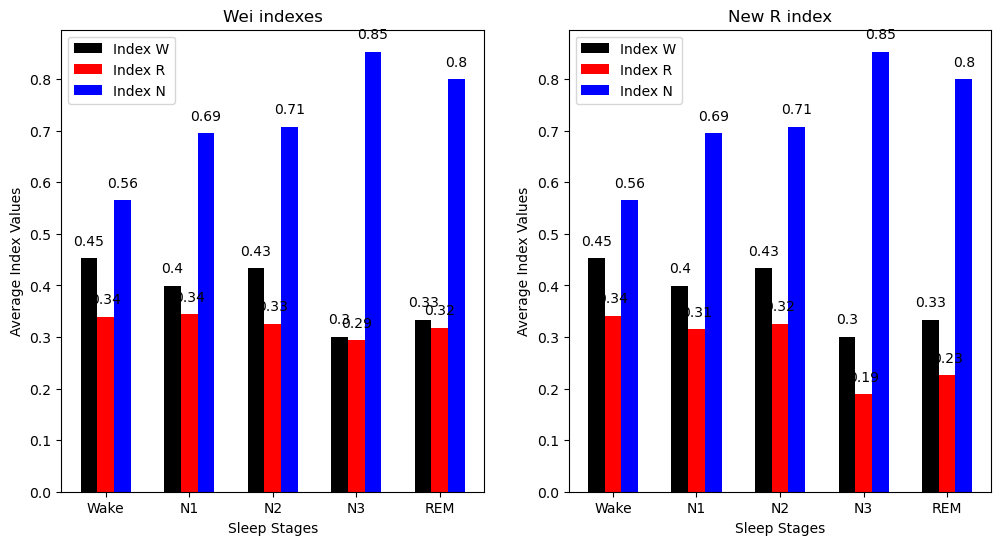

In [589]:
plt.figure(figsize=(12, 6))

# Wei indexes
plt.subplot(1, 2, 1)
categories = ['Wake', 'N1', "N2", "N3", 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, N1_w, N2_w, N3_w, REM_w]
values_REM = [wake_r, N1_r, N2_r, N3_r, REM_r]
values_NREM = [wake_n, N1_n, N2_n, N3_n, REM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Wei indexes')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')




# New W index
plt.subplot(1, 2, 2)
categories = ['Wake', 'N1', "N2", "N3", 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [nwake_w, nN1_w, nN2_w, nN3_w, nREM_w]
values_REM = [nwake_r, nN1_r, nN2_r, nN3_r, nREM_r]
values_NREM = [nwake_n, nN1_n, nN2_n, nN3_n, nREM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('New R index')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')

plt.savefig(os.path.join(output_path, "index-r_wei-vs-new_all-indices_barplot.svg"), format="svg")

#### New NREM (define and get index)

##### Compute new index + function

In [590]:
nindex_n = nindex_N(delta_norm, sigma_norm, gamma_norm)
nindex_n_log = np.log(nindex_n)
nindex_n_norm = wei_normalizing(nindex_n_log)
nindex_n_smoothed = np.convolve(np.convolve(np.convolve(nindex_n_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

In [591]:
nindex_nv2 = nindex_Nv2(delta_norm, theta_norm, sigma_norm, EMG_norm, gamma_norm)
nindex_nv2_log = np.log(nindex_nv2)
nindex_nv2_norm = wei_normalizing(nindex_nv2_log)
nindex_nv2_smoothed = np.convolve(np.convolve(np.convolve(nindex_nv2_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

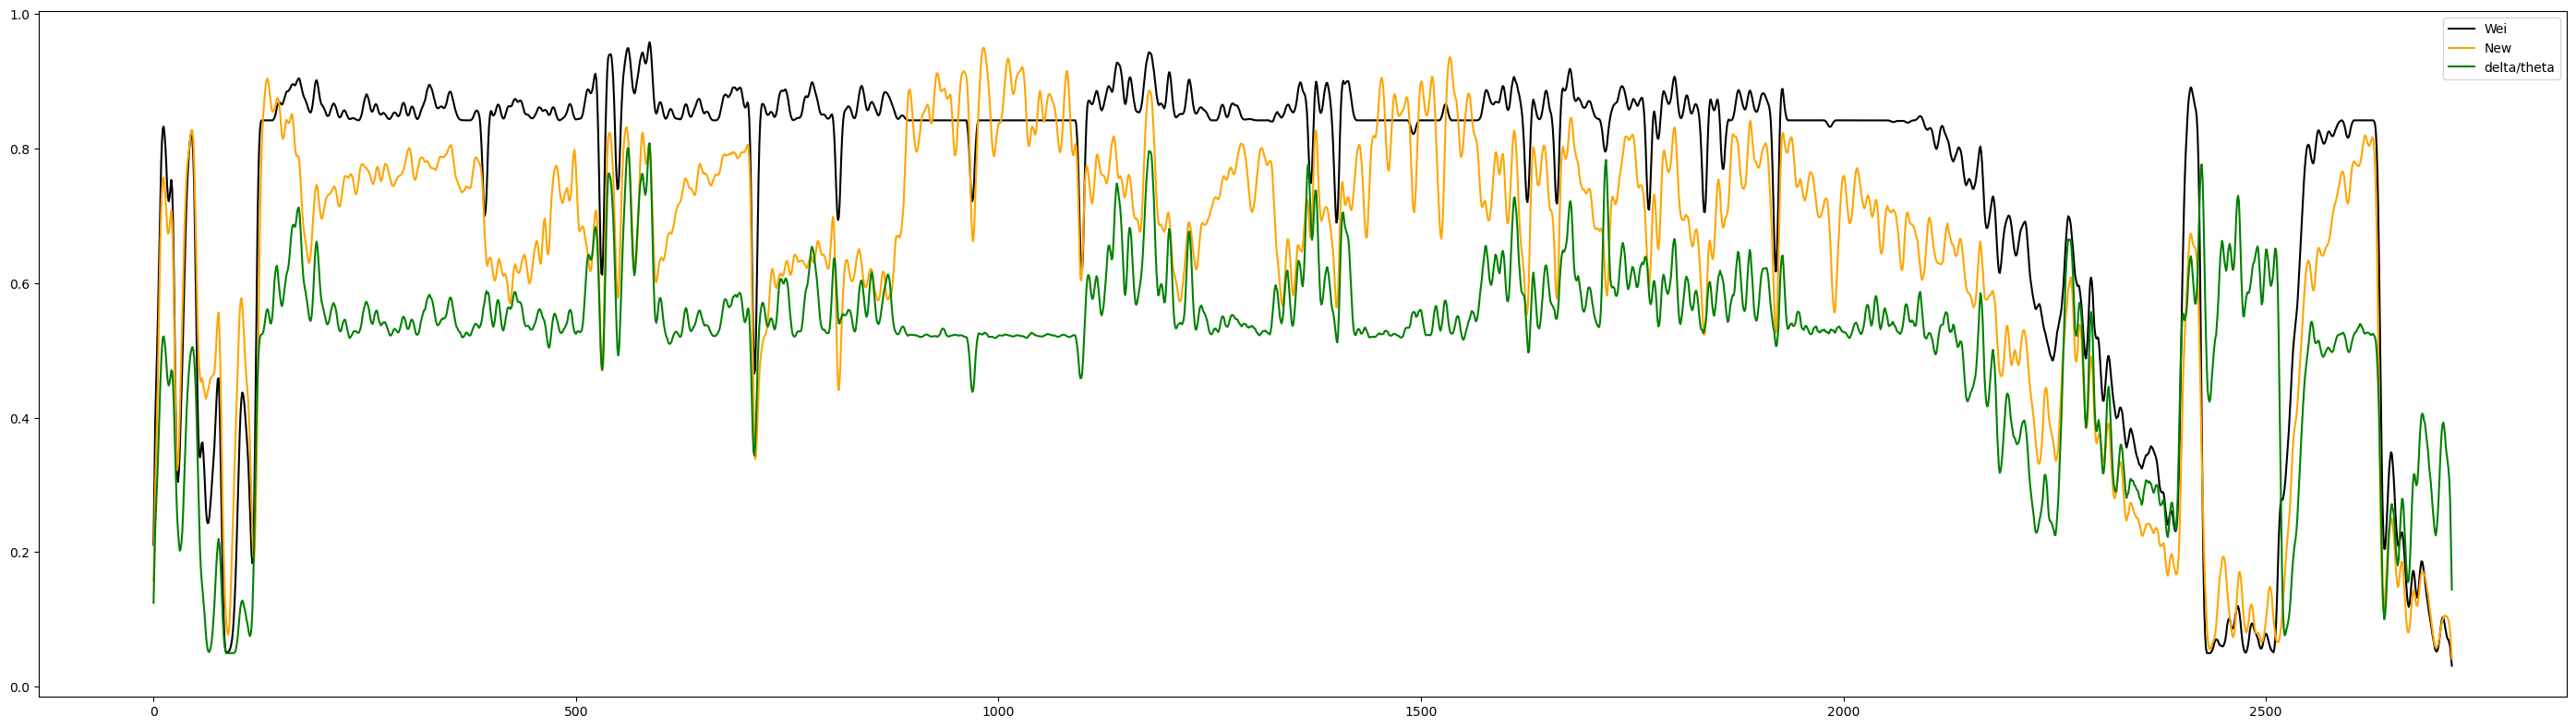

In [592]:
fig, (ax1) = plt.subplots(1, 1, sharex=True, figsize = (28, 8))

# Plot data on each subplot
ax1.plot(epochs, index_n_smoothed, label='Wei', color = 'black')
ax1.plot(epochs, nindex_n_smoothed, label='New', color = 'orange')
ax1.plot(epochs, nindex_nv2_smoothed, label='delta/theta', color = 'green')

# Add legendsg
ax1.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "index-n_wei-vs-new.svg"), format="svg")

# Show the plots
plt.show()

##### All indices plot

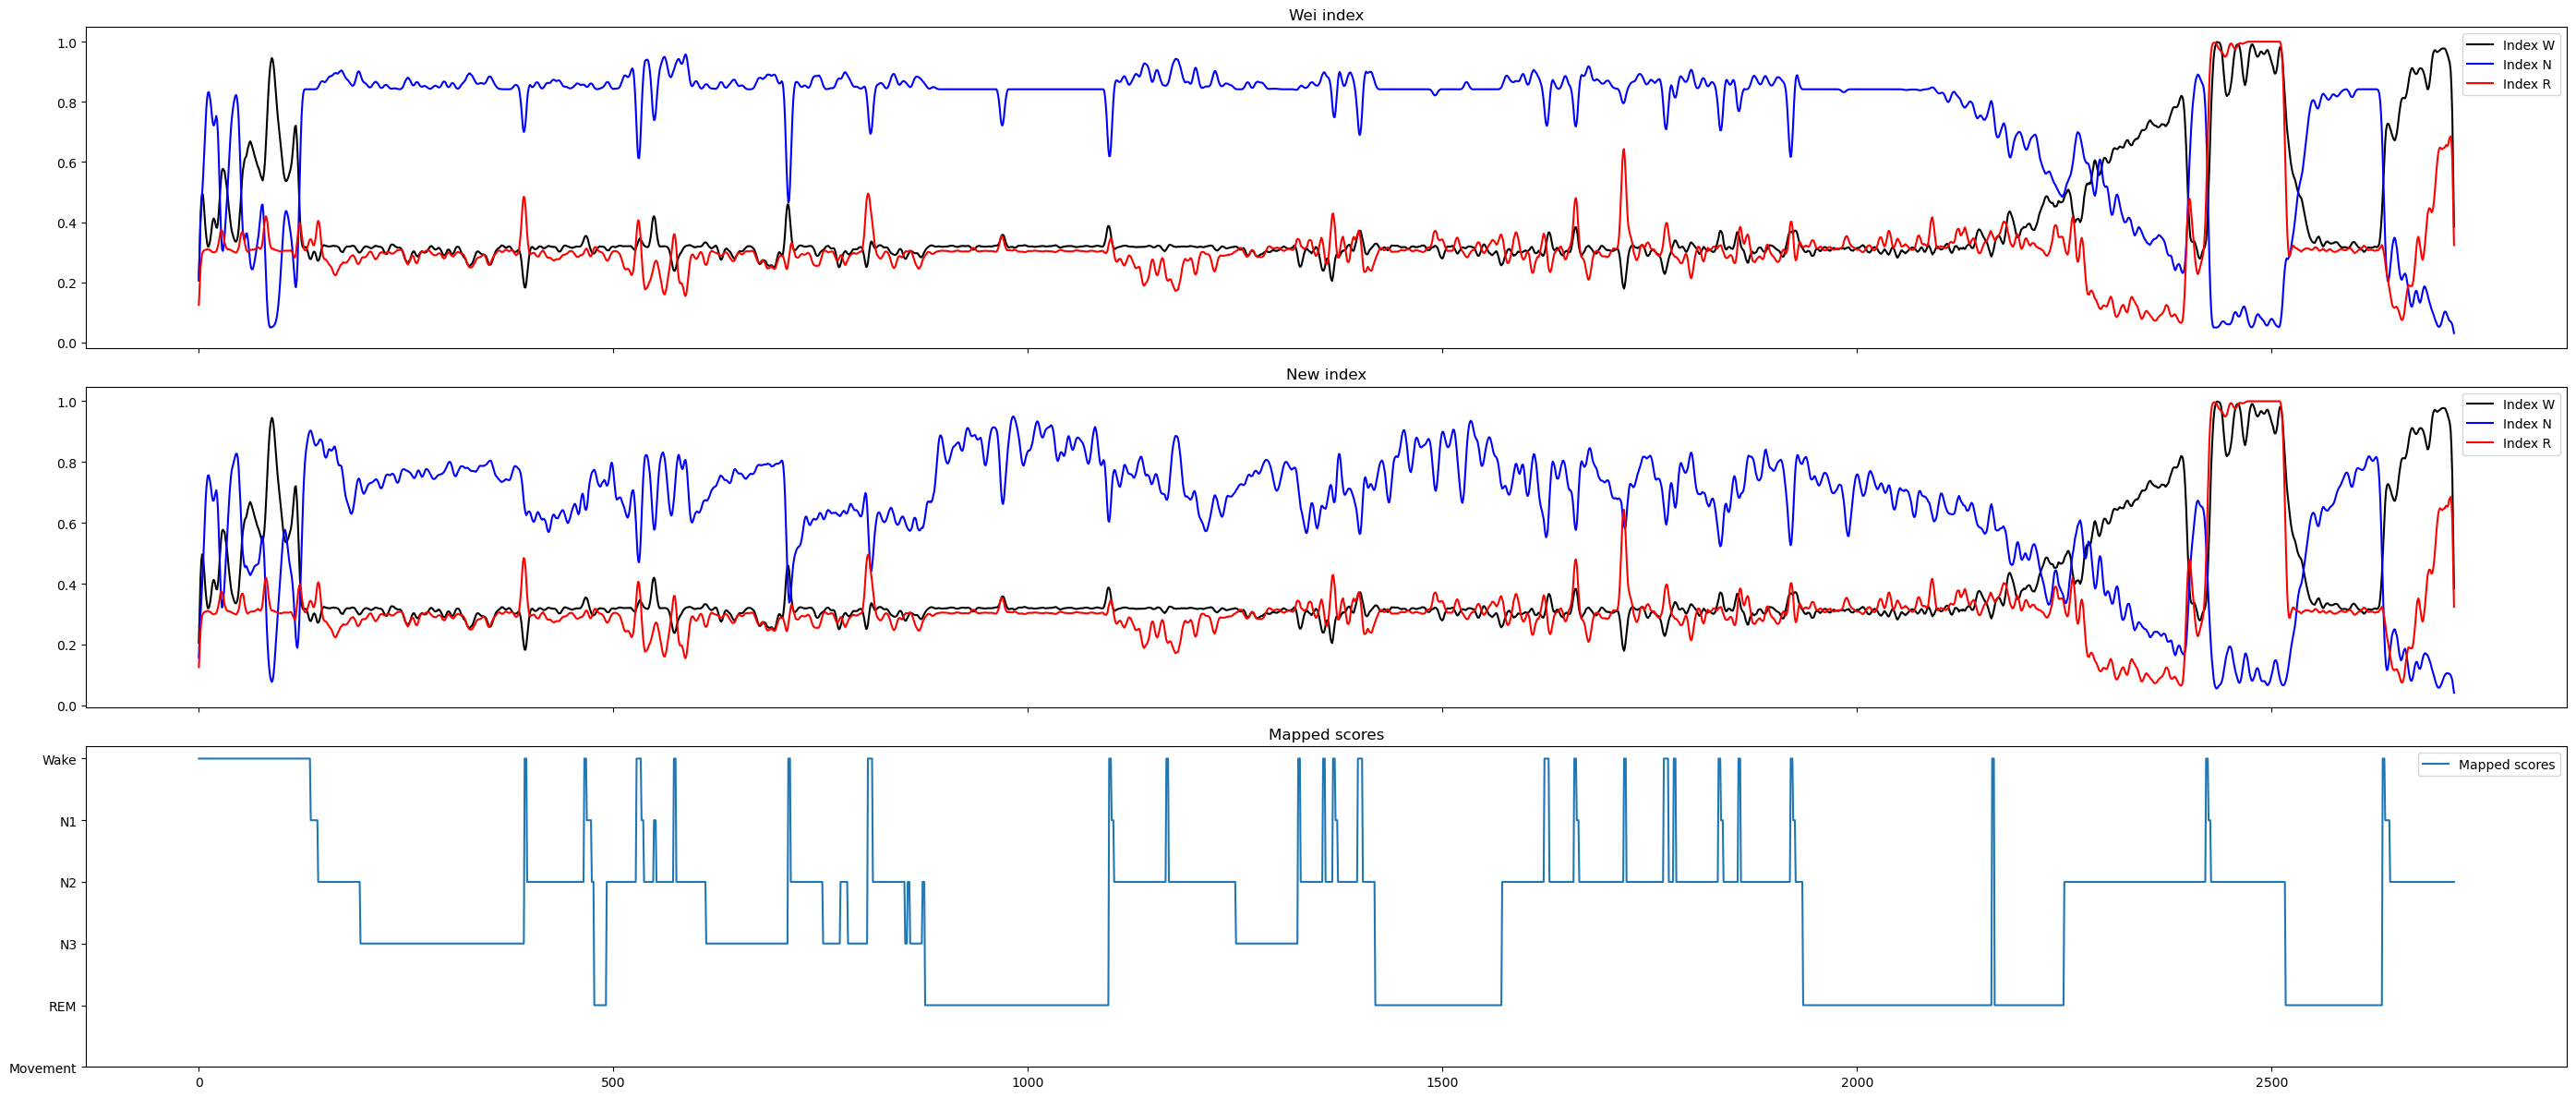

In [593]:
# All indices smoothed for better visualisation

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 12))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax1.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax1.plot(epochs, index_r_smoothed, label='Index R', color ='red')

ax2.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax2.plot(epochs, nindex_n_smoothed, label='Index N', color ='blue')
ax2.plot(epochs, index_r_smoothed, label='Index R', color ='red')


ax3.plot(epochs, majority_scores, label='Mapped scores')

# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei index')
ax2.set_title('New index')
ax3.set_title('Mapped scores')
ax3.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax3.invert_yaxis()

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "index-n_wei-vs-new_all-indices.svg"), format="svg")

# Show the plots
plt.show()

##### Barplots

###### Prerequisites

In [594]:
# New
nindex_Wake = [[],[],[]]
nindex_N1 = [[],[],[]]
nindex_N2 = [[],[],[]]
nindex_N3 = [[],[],[]]
nindex_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    nindex_Wake[0].append(index_w_smoothed[i])
    nindex_Wake[1].append(index_r_smoothed[i])
    nindex_Wake[2].append(nindex_n_smoothed[i])

  elif el == 'N1':
    nindex_N1[0].append(index_w_smoothed[i])
    nindex_N1[1].append(index_r_smoothed[i])
    nindex_N1[2].append(nindex_n_smoothed[i])

  elif el == 'N2':
    nindex_N2[0].append(index_w_smoothed[i])
    nindex_N2[1].append(index_r_smoothed[i])
    nindex_N2[2].append(nindex_n_smoothed[i])

  elif el == 'N3':
    nindex_N3[0].append(index_w_smoothed[i])
    nindex_N3[1].append(index_r_smoothed[i])
    nindex_N3[2].append(nindex_n_smoothed[i])

  elif el == 'REM':
    nindex_REM[0].append(index_w_smoothed[i])
    nindex_REM[1].append(index_r_smoothed[i])
    nindex_REM[2].append(nindex_n_smoothed[i])

In [595]:
# New
nwake_w = np.average(nindex_Wake[0])
nwake_r = np.average(nindex_Wake[1])
nwake_n = np.average(nindex_Wake[2])
nN1_w = np.average(nindex_N1[0])
nN1_r = np.average(nindex_N1[1])
nN1_n = np.average(nindex_N1[2])
nN2_w = np.average(nindex_N2[0])
nN2_r = np.average(nindex_N2[1])
nN2_n = np.average(nindex_N2[2])
nN3_w = np.average(nindex_N3[0])
nN3_r = np.average(nindex_N3[1])
nN3_n = np.average(nindex_N3[2])
nREM_w = np.average(nindex_REM[0])
nREM_r = np.average(nindex_REM[1])
nREM_n = np.average(nindex_REM[2])

###### Barplots

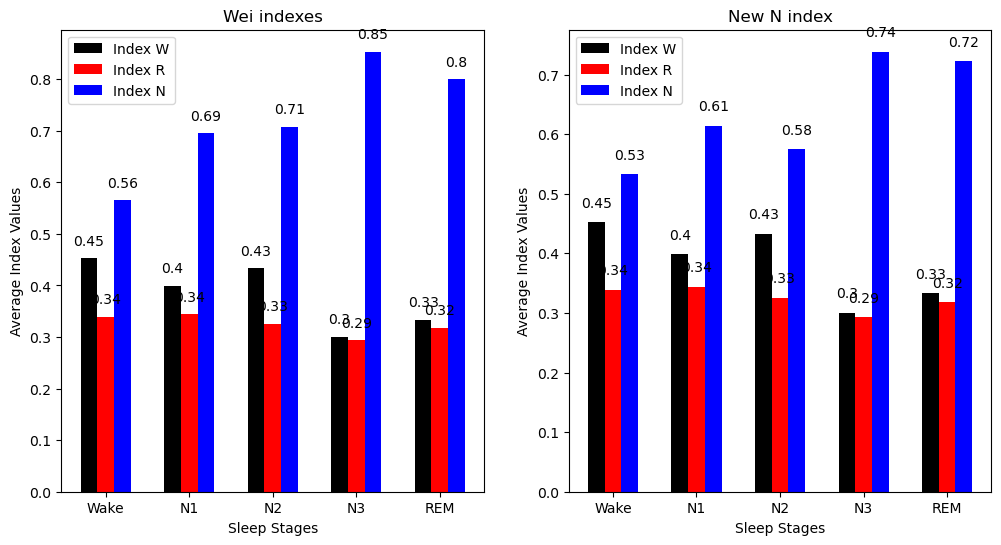

In [596]:
plt.figure(figsize=(12, 6))

# categories = ['Wake', 'N1', "N2", "N3", 'REM']
# index_types = ['Index_w', 'Index_r', 'Index_n']
# values_wake = [nwake_w, nN1_w, nN2_w, nN3_w, nREM_w]
# values_REM = [nwake_r, nN1_r, nN2_r, nN3_r, nREM_r]
# values_NREM = [nwake_n, nN1_n, nN2_n, nN3_n, nREM_n]

# Wei indexes
plt.subplot(1, 2, 1)
categories = ['Wake', 'N1', "N2", "N3", 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, N1_w, N2_w, N3_w, REM_w]
values_REM = [wake_r, N1_r, N2_r, N3_r, REM_r]
values_NREM = [wake_n, N1_n, N2_n, N3_n, REM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Wei indexes')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')




# New W index
plt.subplot(1, 2, 2)
categories = ['Wake', 'N1', "N2", "N3", 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [nwake_w, nN1_w, nN2_w, nN3_w, nREM_w]
values_REM = [nwake_r, nN1_r, nN2_r, nN3_r, nREM_r]
values_NREM = [nwake_n, nN1_n, nN2_n, nN3_n, nREM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('New N index')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')

plt.savefig(os.path.join(output_path, "index-n_wei-vs-new_all-indices_barplot.svg"), format="svg")

### Comparing Wei vs New

#### Plot

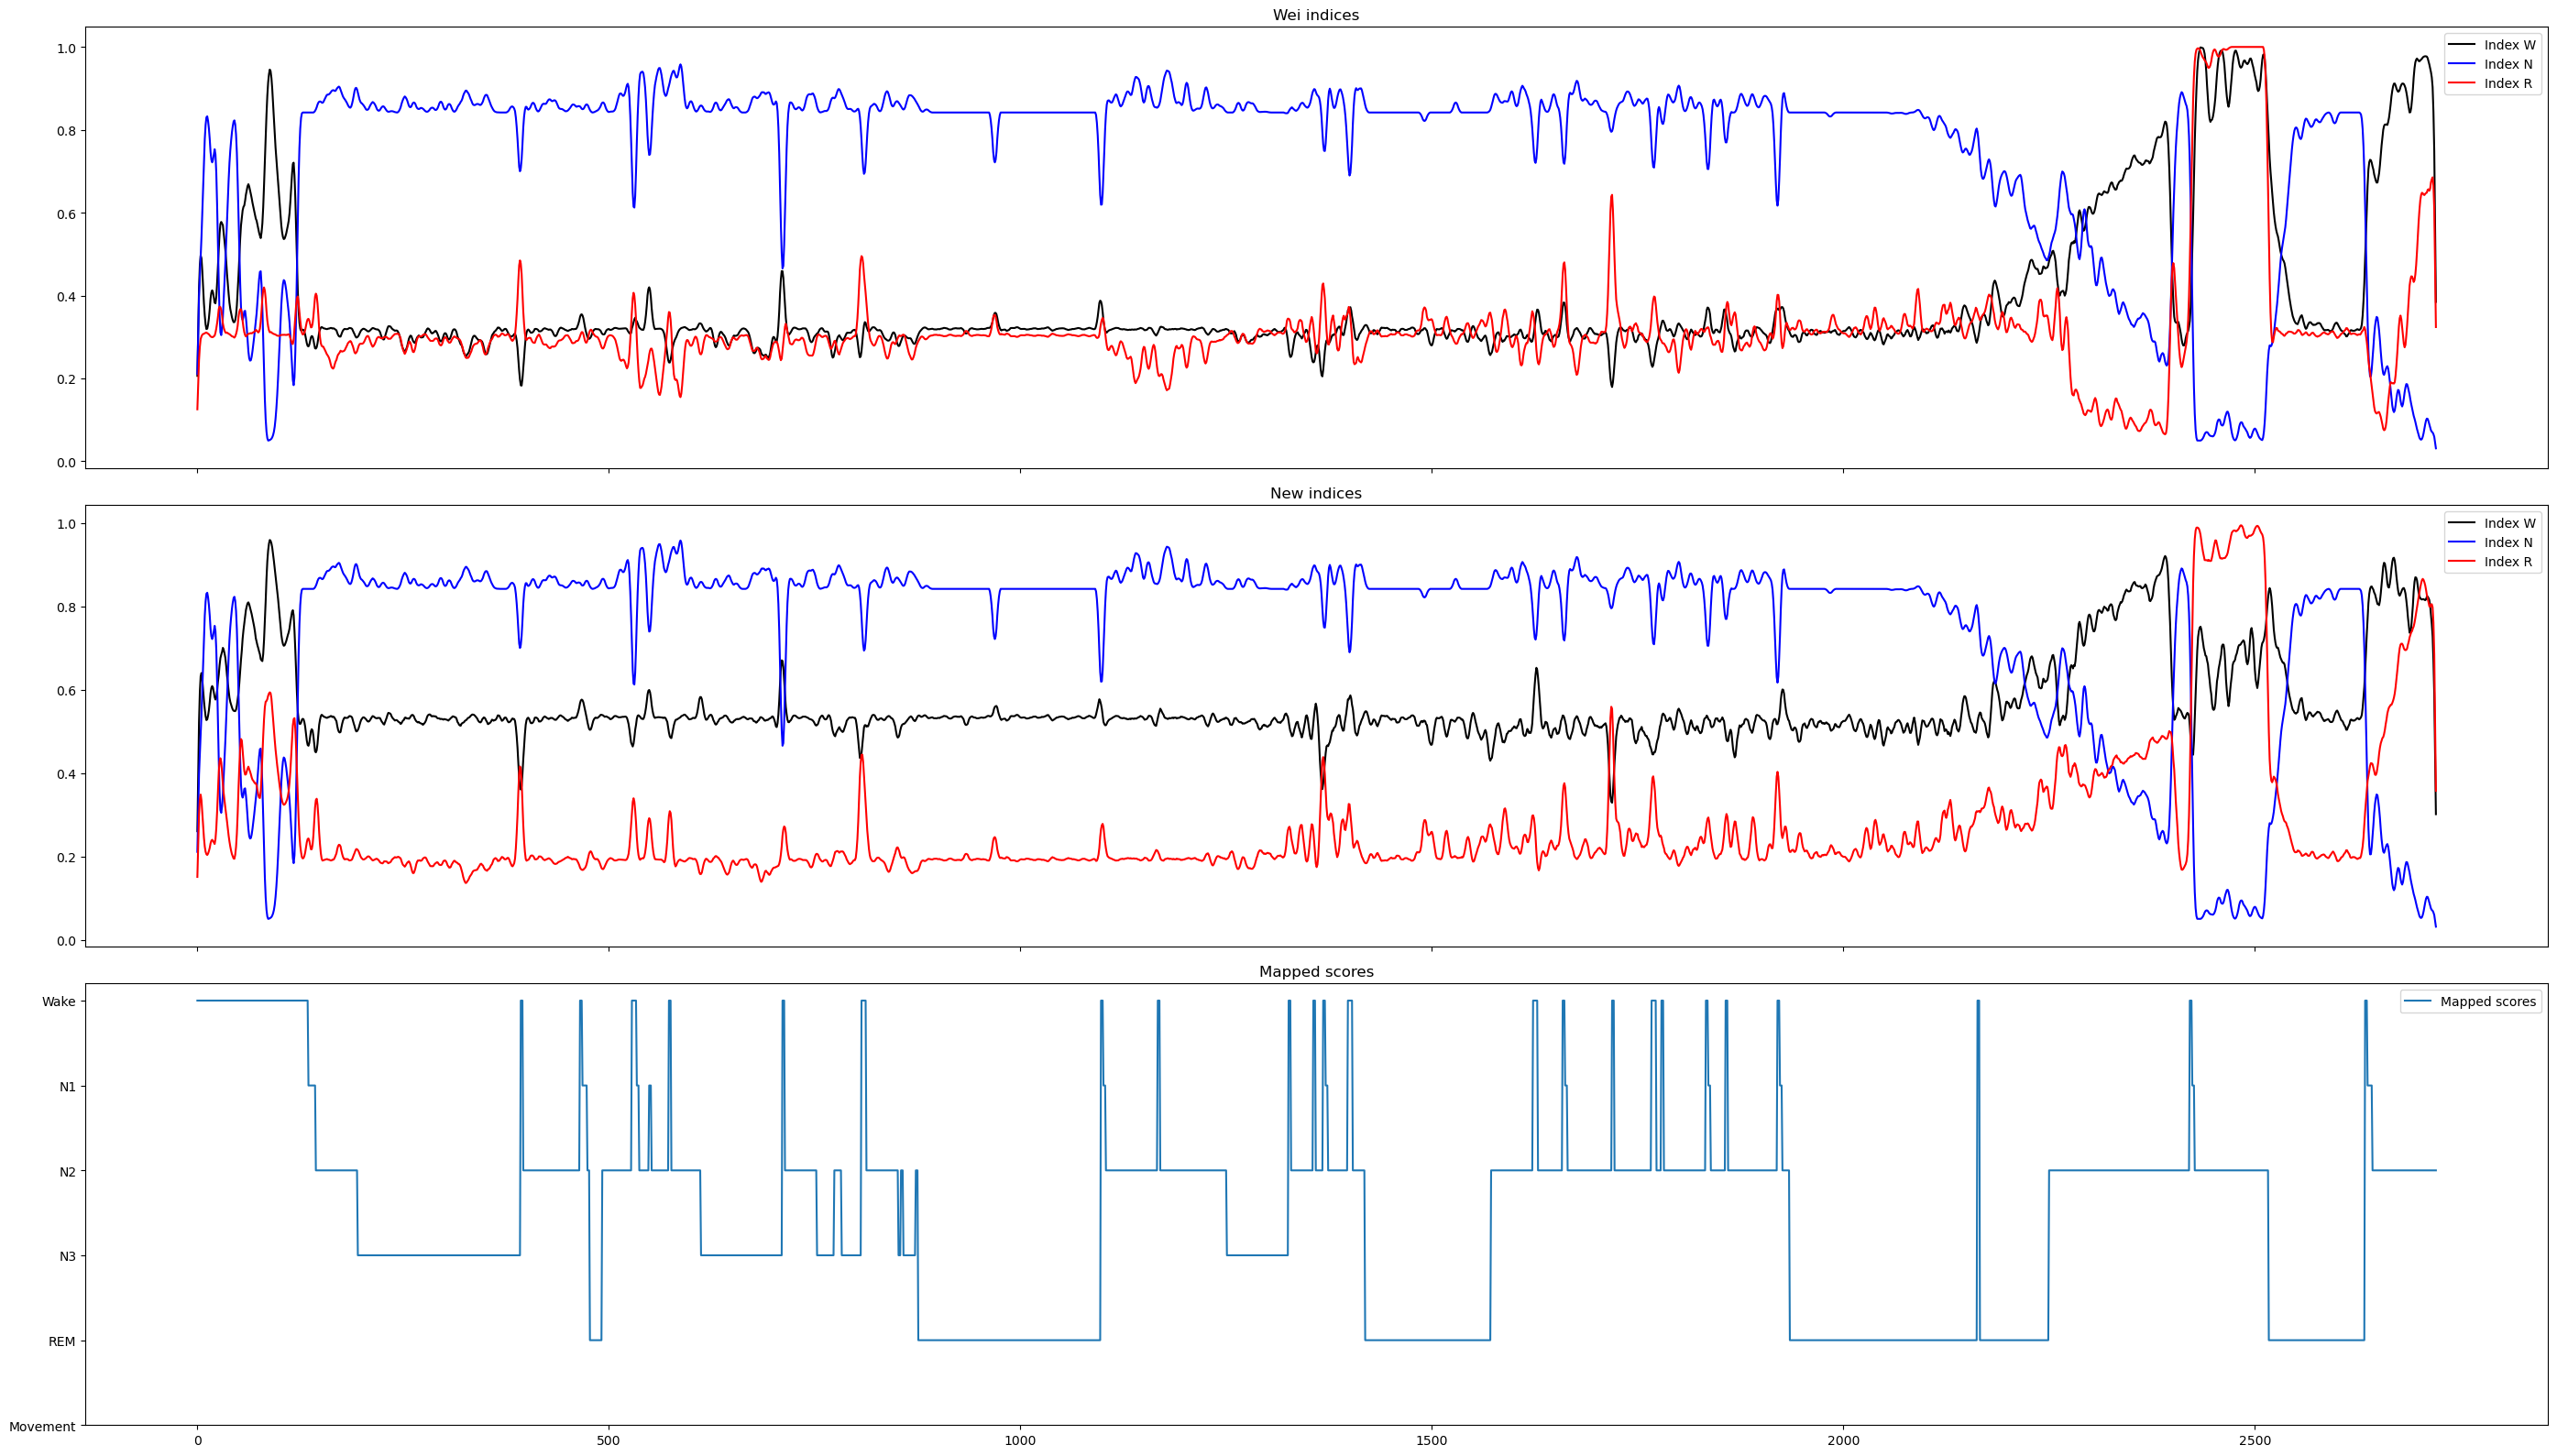

In [597]:
# All main indices
times = np.arange(0, len(epochs))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 16))

# Plot data on each subplot
ax1.plot(epochs[times], index_w_smoothed[times], label='Index W', color='black')
ax1.plot(epochs[times], index_n_smoothed[times], label='Index N', color='blue')
ax1.plot(epochs[times], index_r_smoothed[times], label='Index R', color='red')

ax2.plot(epochs[times], nindex_w_smoothed[times], label='Index W', color='black')
ax2.plot(epochs[times], index_n_smoothed[times], label='Index N', color='blue')
ax2.plot(epochs[times], nindex_r_smoothed[times], label='Index R', color='red')

ax3.plot(epochs[times], majority_scores[times], label='Mapped scores')



# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei indices')
ax2.set_title('New indices')
ax3.set_title('Mapped scores')
ax3.set_yticks(ticks=[0,1,2,3,4,5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
ax3.invert_yaxis()

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig(os.path.join(output_path, "wei-indices_vs_new-indices.svg"), format="svg")

# Show the plots
plt.show()

In [598]:
# # All main indices
# times = np.arange(2000, 3000)
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 16))

# # Plot data on each subplot
# ax1.plot(epochs[times], index_w_smoothed[times], label='Index W', color='black')
# ax1.plot(epochs[times], index_n_smoothed[times], label='Index N', color='blue')
# ax1.plot(epochs[times], index_r_smoothed[times], label='Index R', color='red')

# ax2.plot(epochs[times], nindex_w_smoothed[times], label='Index W', color='black')
# ax2.plot(epochs[times], index_n_smoothed[times], label='Index N', color='blue')
# ax2.plot(epochs[times], nindex_r_smoothed[times], label='Index R', color='red')

# ax3.plot(epochs[times], mapped_scores[times], label='Mapped scores')



# # Add legends
# ax1.legend()
# ax2.legend()
# ax3.legend()

# # Add titles
# ax1.set_title('Wei indices')
# ax2.set_title('New indices')
# ax3.set_title('Mapped scores')
# #ax3.invert_yaxis()
# # ax3.set_yticks([0,1,2,3,4])
# # ax3.set_yticklabels(["Wake", "N1", "N2", "N3", "REM"])
# ax3.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Wake", "N1", "N2", "N3", "REM", "Movement"])
# ax3.invert_yaxis


# # Adjust layout to avoid overlap
# plt.tight_layout()

# plt.savefig(os.path.join(output_path, "wei-indices_vs_new-indices_timeframe.svg"), format="svg")
# # Show the plots
# plt.show()

#### Barplots

###### Prerequisites

In [599]:
# New
nindex_Wake = [[],[],[]]
nindex_N1 = [[],[],[]]
nindex_N2 = [[],[],[]]
nindex_N3 = [[],[],[]]
nindex_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    nindex_Wake[0].append(nindex_w_smoothed[i])
    nindex_Wake[1].append(nindex_r_smoothed[i])
    nindex_Wake[2].append(index_n_smoothed[i])

  elif el == 'N1':
    nindex_N1[0].append(nindex_w_smoothed[i])
    nindex_N1[1].append(nindex_r_smoothed[i])
    nindex_N1[2].append(index_n_smoothed[i])

  elif el == 'N2':
    nindex_N2[0].append(nindex_w_smoothed[i])
    nindex_N2[1].append(nindex_r_smoothed[i])
    nindex_N2[2].append(index_n_smoothed[i])

  elif el == 'N3':
    nindex_N3[0].append(nindex_w_smoothed[i])
    nindex_N3[1].append(nindex_r_smoothed[i])
    nindex_N3[2].append(index_n_smoothed[i])

  elif el == 'REM':
    nindex_REM[0].append(nindex_w_smoothed[i])
    nindex_REM[1].append(nindex_r_smoothed[i])
    nindex_REM[2].append(index_n_smoothed[i])

In [600]:
# New
nwake_w = np.average(nindex_Wake[0])
nwake_r = np.average(nindex_Wake[1])
nwake_n = np.average(nindex_Wake[2])
nN1_w = np.average(nindex_N1[0])
nN1_r = np.average(nindex_N1[1])
nN1_n = np.average(nindex_N1[2])
nN2_w = np.average(nindex_N2[0])
nN2_r = np.average(nindex_N2[1])
nN2_n = np.average(nindex_N2[2])
nN3_w = np.average(nindex_N3[0])
nN3_r = np.average(nindex_N3[1])
nN3_n = np.average(nindex_N3[2])
nREM_w = np.average(nindex_REM[0])
nREM_r = np.average(nindex_REM[1])
nREM_n = np.average(nindex_REM[2])

In [601]:
if 'Wake' not in mapped_scores:
  nwake_w = 0
  nwake_r = 0
  nwake_n = 0
if 'REM' not in mapped_scores:
  nREM_w = 0
  nREM_r = 0
  nREM_n = 0
if 'N1' not in mapped_scores:
  nN1_w = 0
  nN1_r = 0
  nN1_n = 0
if 'N2' not in mapped_scores:
  nN2_w = 0
  nN2_r = 0
  nN2_n = 0
if 'N3' not in mapped_scores:
  nN3_w = 0
  nN3_r = 0
  nN3_n = 0

###### Barplots

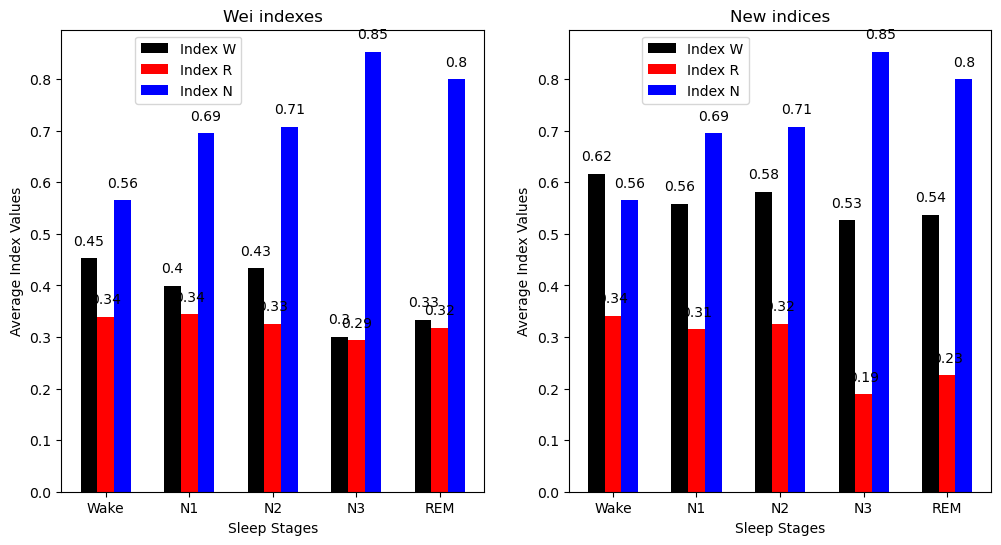

In [602]:
plt.figure(figsize=(12, 6))

# Wei indexes
plt.subplot(1, 2, 1)
categories = ['Wake', 'N1', "N2", "N3", 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, N1_w, N2_w, N3_w, REM_w]
values_REM = [wake_r, N1_r, N2_r, N3_r, REM_r]
values_NREM = [wake_n, N1_n, N2_n, N3_n, REM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Wei indexes')
plt.xticks(x, categories)
plt.legend(loc='upper center', bbox_to_anchor=(0.3, 1))

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')




# New W index
plt.subplot(1, 2, 2)
categories = ['Wake', 'N1', "N2", "N3", 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [nwake_w, nN1_w, nN2_w, nN3_w, nREM_w]
values_REM = [nwake_r, nN1_r, nN2_r, nN3_r, nREM_r]
values_NREM = [nwake_n, nN1_n, nN2_n, nN3_n, nREM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('New indices')
plt.xticks(x, categories)
plt.legend(loc='upper center', bbox_to_anchor=(0.3, 1))

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')

plt.savefig(os.path.join(output_path, "wei-indices_vs_new-indices_barplot.svg"), format="svg")

plt.show()

2721
2721
[[0.26040096 0.15648989 0.15060595 ... 0.05190275 0.0204     0.0204    ]
 [0.38908403 0.22432656 0.22557238 ... 0.07580026 0.03       0.03      ]
 [0.52256378 0.29929898 0.29986158 ... 0.09952086 0.04       0.04      ]
 ...
 [0.58876547 0.08154644 0.68453855 ... 0.04259143 0.10816376 0.04122593]
 [0.44341706 0.0609619  0.51826686 ... 0.03172762 0.08227535 0.03061297]
 [0.30118918 0.04152782 0.35712729 ... 0.02143657 0.05696873 0.02060432]]


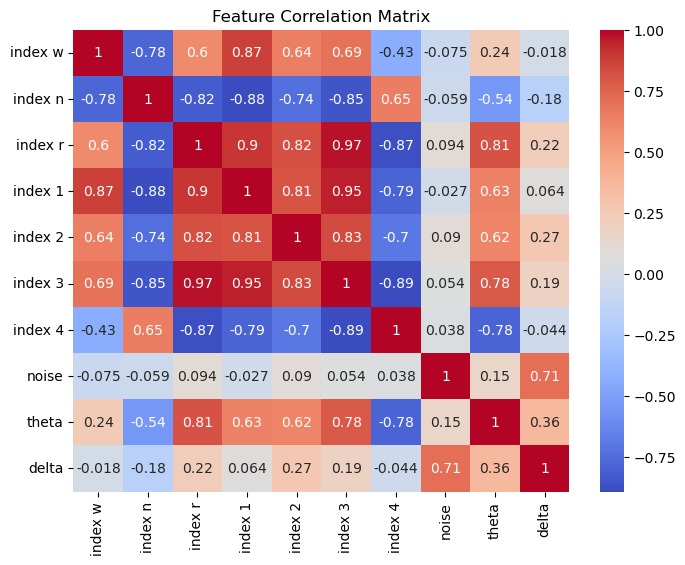

[[-0.5538942  -0.87887812]
 [ 0.06624898 -0.49503118]
 [ 0.67424123 -0.11008135]
 ...
 [ 6.26381553 -1.38693348]
 [ 4.28646102 -1.49469452]
 [ 2.37431996 -1.5846568 ]]


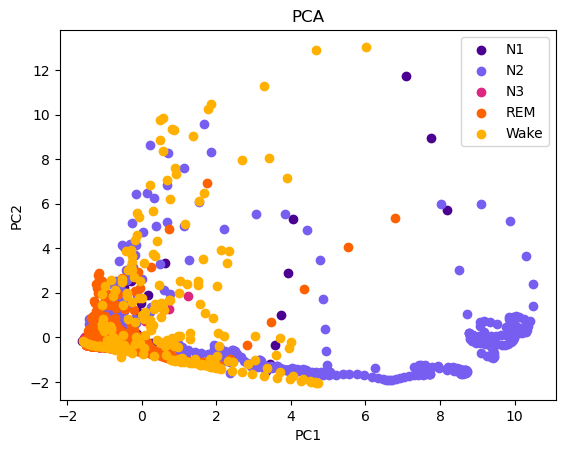

In [603]:
print(len(nindex_n_smoothed))
print(len(mapped_scores))

arrays = [
    nindex_w_smoothed, 
    nindex_n_smoothed, 
    nindex_r_smoothed,
    index_1_smoothed, 
    index_2_smoothed, 
    index_3_smoothed, 
    index_4_smoothed, 
    noise_smoothed, 
    theta_smoothed, 
    delta_smoothed
]
array = np.column_stack(arrays)
print(array)

df = pd.DataFrame(array)
x = df
y = mapped_scores


# If you *do* have feature names in a list
feature_names = [f"f{i}" for i in range(array.shape[1])]  # or your own names
df = pd.DataFrame(array, columns=feature_names)

states = pd.DataFrame({"states": upsampled_states})
 
corr = df.corr()
plt.figure(figsize=(8,6))
feature_names = ["index w", "index n", "index r", "index 1","index 2","index 3","index 4","noise","theta", "delta"]
sns.heatmap(corr, annot=True, cmap="coolwarm", yticklabels = feature_names, xticklabels = feature_names)
#plt.yticks(["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9"], ["index w", "index n", "index r", "index 1","index 2","index 3","index 4","noise","theta", "delta"])
plt.title("Feature Correlation Matrix")
plt.savefig(os.path.join(output_path, "feature_correlation.svg"), format="svg")
plt.show()

# X = df.values
# vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# for i, v in enumerate(vif):
#     print(f"Feature {df.columns[i]}: VIF={v:.2f}")

# # Standardize
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(x)

# # PCA
# pca = PCA(n_components=3)
# X_pca = pca.fit_transform(X_scaled)

# # Put PCA results into a DataFrame
# df_pca = pd.DataFrame({
#     'PC1': X_pca[:, 0],
#     'PC2': X_pca[:, 1],
#     'PC3': X_pca[:, 2],
#     'label': y  # your label array
# })

# # Define custom colors if you want
# color_discrete_map = {
#     label: color for label, color in zip(np.unique(y), ['#4B0092', '#785EF0', '#DC267F', '#FE6100', '#FFB000', '#648FFF'])
# }

# # 3D scatter plot
# fig = px.scatter_3d(
#     df_pca, x='PC1', y='PC2', z='PC3',
#     color='label',
#     color_discrete_map=color_discrete_map,
#     symbol='label',  # optional, can differentiate with marker symbols
#     opacity=0.8,
#     size_max=10
# )

# fig.update_layout(
#     scene=dict(
#         xaxis_title='PC1',
#         yaxis_title='PC2',
#         zaxis_title='PC3'
#     ),
#     title="3D PCA Plot"
# )

# fig.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(X_pca)

colors = ['#4B0092', '#785EF0', '#DC267F', '#FE6100', '#FFB000', '#648FFF']

for i, label in enumerate(np.unique(y)):
    plt.scatter(X_pca[y==label, 0], X_pca[y==label, 1], color=colors[i % len(colors)], label=label)
    # plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
plt.legend()
plt.savefig(os.path.join(output_path, "pca_wnr-indices.svg"), format="svg")
plt.show()

# 3D temporal visualisation of index evolution

In [604]:
# import plotly.express as px
# import pandas as pd

# df = pd.DataFrame({
#     'summed_emg': savgol_filter(EMG_norm, window_length=101, polyorder=4)[0:1000],               # you want to choose a time interval where you can see a whole wake-nrem-rem-nrem cycle
#     'normalized_delta_power': savgol_filter(delta_norm, window_length=101, polyorder=4)[0:1000],  # extra smoothing so that we can actullay see something
#     'normalized_theta_power': savgol_filter(theta_norm, window_length=101, polyorder=4)[0:1000]
# })

# fig = px.scatter_3d(df, x='normalized_theta_power', y='normalized_delta_power', z='summed_emg',
#                     title='',
#                     color=df.index,
#                     color_continuous_scale='Magma',
#                     opacity=0.8)

# fig.update_layout(width=1000, height=900)
# fig.show()

In [619]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(array, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [620]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm = SVC(kernel='rbf', C=1, gamma='scale')  # linear or rbf are common
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8403669724770643
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.87      0.92      0.89       239
           2       0.96      0.53      0.69        86
           3       0.78      0.98      0.87       170
           4       0.84      0.62      0.71        42

    accuracy                           0.84       545
   macro avg       0.69      0.61      0.63       545
weighted avg       0.84      0.84      0.83       545



c:\Users\andri\miniconda3\envs\rodent_model\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andri\miniconda3\envs\rodent_model\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andri\miniconda3\envs\rodent_model\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [621]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm, array, y_encoded, cv=5)
print("Cross-val accuracy:", scores.mean())

Cross-val accuracy: 0.6670277927684836


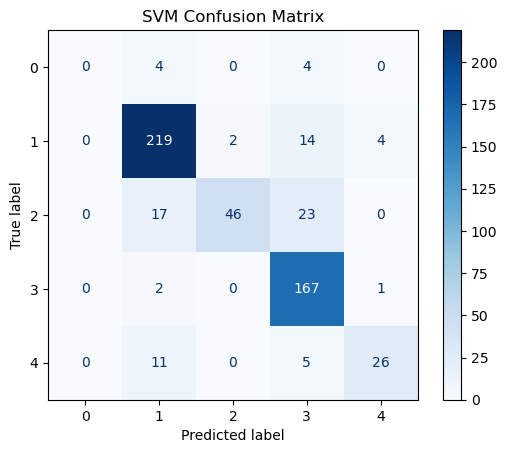

In [611]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

In [624]:
from sklearn.decomposition import PCA
import numpy as np

# Reduce to 2D for visualization
pca = PCA(n_components=5)
X_vis = pca.fit_transform(array)

svm.fit(X_vis, y_encoded)

# Create grid for decision boundary
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_vis[:, 0], X_vis[:, 2], c=y_encoded, edgecolor='k', cmap='coolwarm')
plt.title("SVM Decision Boundary (PCA-reduced EEG features)")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

ValueError: X has 2 features, but SVC is expecting 5 features as input.

In [617]:
import numpy as np

print(type(array), array.dtype)
print(type(y))

print(np.isfinite(array).all())

try:
    np.isfinite(y)
    print("y is numeric")
except Exception as e:
    print("y problem:", e)
    print("Sample y:", y[:10])

<class 'numpy.ndarray'> float64
<class 'numpy.ndarray'>
True
y problem: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Sample y: ['Wake' 'Wake' 'Wake' 'Wake' 'Wake' 'Wake' 'Wake' 'Wake' 'Wake' 'Wake']
